# Integral Field Spectrograph (IFS)--Keck Cosmic Web Imager (KCWI) Spaxel-wise analysis
### This notebook walks through important methodology that have to be used when analyzing IFS data. However, the following codes are specifically designed for KCWI, so reader may need to change some of the details. (the idea should be the same.)

Author: Yuanze Ding, for his second year project with KBSS-KCWI cosmic noon AGN.
**Aug 20, 2023**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
import scienceplots

import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel

from scipy.signal import find_peaks


from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import estimate_line_parameters,fit_lines,find_lines_threshold
from specutils.manipulation import extract_region

from photutils.aperture import EllipticalAperture, SkyEllipticalAperture

import os, sys, glob, pdb

from importlib import reload
import pyregion as pyreg
from spectral_cube import SpectralCube
from reproject import reproject_interp
from regions import Regions
import linetools


from frb.frb import FRB
from frb.analysis import kcwi
brightu = r"Brightness $\rm (10^{-4}~erg~s^{-1}~arcsec^{-2}~cm^{-2}~\AA^{-1})$"
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 10*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax
KBSSpath="/disk/bifrost/yuanze/KBSS"
cubename="Q0100"
sourcename="BX172"
redshift=2.3118
datapath=KBSSpath+"/"+cubename+"/"+sourcename

# Reading data with spectra-cube package

The extraction region was predetermined from DS9. I can also do that with other methods, e.g. isophotal radius determined from HST image. In that case, we need regions package.

In [138]:
#Data read
cubefile = datapath+"/kcwi_oned/q0100-BX172_icubes_wcs.fits"
varfile = datapath+"/kcwi_oned/q0100-BX172_vcubes.fits"

inicube = SpectralCube.read(cubefile) 
inivarcube = SpectralCube.read(varfile)
iniwcs=inicube.wcs.celestial

In [12]:
#Region file reading: Extract useful region
img = kcwi.get_img(cubefile) #getting white light image
regfile="/disk/bifrost/yuanze/KBSS/Q1549/BX101/reg1.reg"
reg = pyreg.open(regfile).as_imagecoord(img.header)
myfilter=reg.get_filter()



mask1 = myfilter[0].mask(img.data)
mask2 = myfilter[1].mask(img.data)
mask3 = myfilter[2].mask(img.data)
maskce = myfilter[3].mask(img.data)
maskg = myfilter[5].mask(img.data)
plumask = (myfilter[5] and ~myfilter[3]).mask(img.data)

In [139]:
#reg = Regions.read(regfile,format='ds9')
regions_str1 = '# Region file format: DS9\nimage\ncircle(39.647001, 63.710734,6) # color=green\n'
regions_str2 = '# Region file format: DS9\nimage\nbox(58.558461,44.895089,43.412701,31.590492,0) # color=magenta\n'
rl=[]
rl.append(Regions.parse(regions_str1, format='ds9'))
rl.append(Regions.parse(regions_str2, format='ds9'))

In [14]:
redshift = 2.3118  # BX172

cube = inicube.subcube_from_mask(maskg)
varcube = inivarcube.subcube_from_mask(maskg)
spat_wcs = cube.wcs.celestial
sub_cube = cube.spectral_slab(1208*u.AA*(1+redshift), 1230*u.AA*(1+redshift))
sub_varcube = varcube.spectral_slab(1208*u.AA*(1+redshift), 1230*u.AA*(1+redshift))

sub_varcube2 = sub_varcube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
sub_cube2 = sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)

kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
sub_varcube2 = sub_varcube2.spatial_smooth(kernel)
sub_cube2 = sub_cube2.spatial_smooth(kernel)

# Derivation of Averaged Nuclear UV Spectrum

## Define extraction region 

In [141]:
from regions.core import PixCoord
from regions.shapes.circle import CircleSkyRegion,CirclePixelRegion


In [152]:
center_sky = SkyCoord(ra=15.78524, dec=13.27826, unit='deg', frame='icrs') #BX172
region_sky = CircleSkyRegion(center=center_sky, radius=1.8 * u.arcsec)
region_pix = region_sky.to_pixel(iniwcs)
mask_reg = region_pix.to_mask()
mask_reg = mask_reg.to_image(inicube.shape[1:]).astype(bool)

## Inspect the region that has been selected

In [170]:
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 20*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax

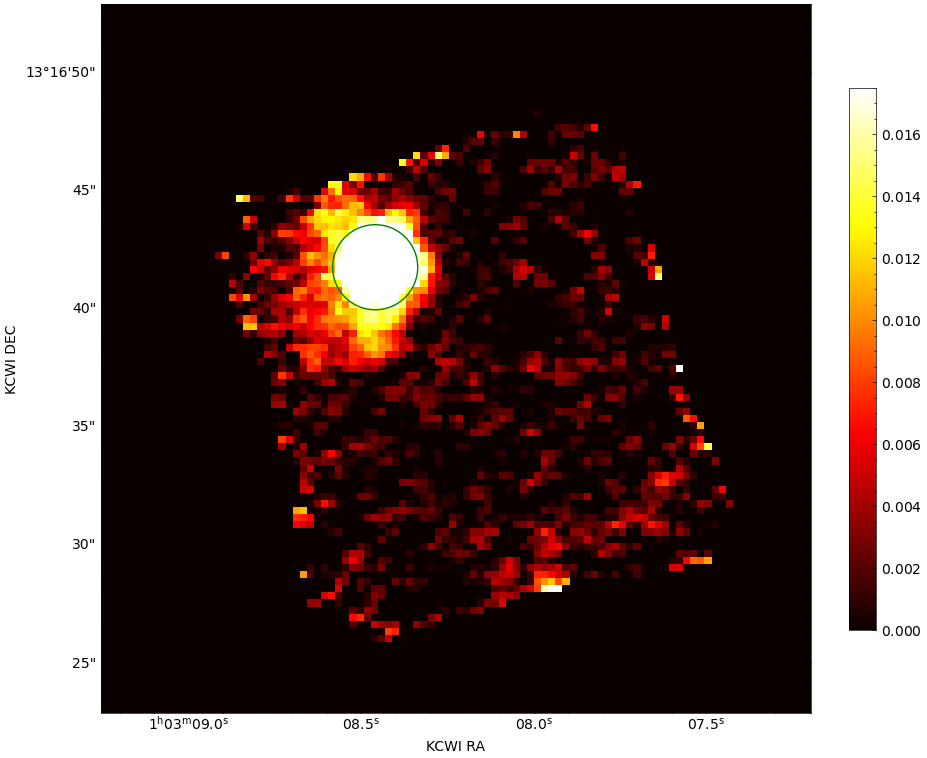

In [173]:
fig, ax = imshow_astro(inicube[804,:,:].value,wcsinfo=iniwcs)
#ax.add_artist(mask_reg.bbox.as_artist(facecolor='none', edgecolor='white'))
ax.add_artist(region_pix.as_artist(facecolor='none', edgecolor='green'))
#ax.set_xlim(120, 180)
#ax.set_ylim(1000, 1059)

In [153]:
spec, varspec = kcwi.spec_from_mask(inicube,mask_reg,inivarcube, kind = "mean")
sigma = np.sqrt(varspec)

In [149]:
# Define the lines that may present in the spectrum

#lines={'C III':[1906.,1909.], 'N V':[1238.821,1242.804], 'C IV':[1548.187,1550.772], 'He II':[1640.4], "Si III":[1206.5],
#      "Si IV":[1393.76,1402.77],"Si II":[1260.42],"C II":[1334.53]}
lines={ 'N V':[1238.821,1242.804], 'C IV':[1549], "Si III":[1206.5],"Lya":[1216],"Si IV":[1393.76,1402.77],"Si II":[1260.42],"C II":[1334.53]}

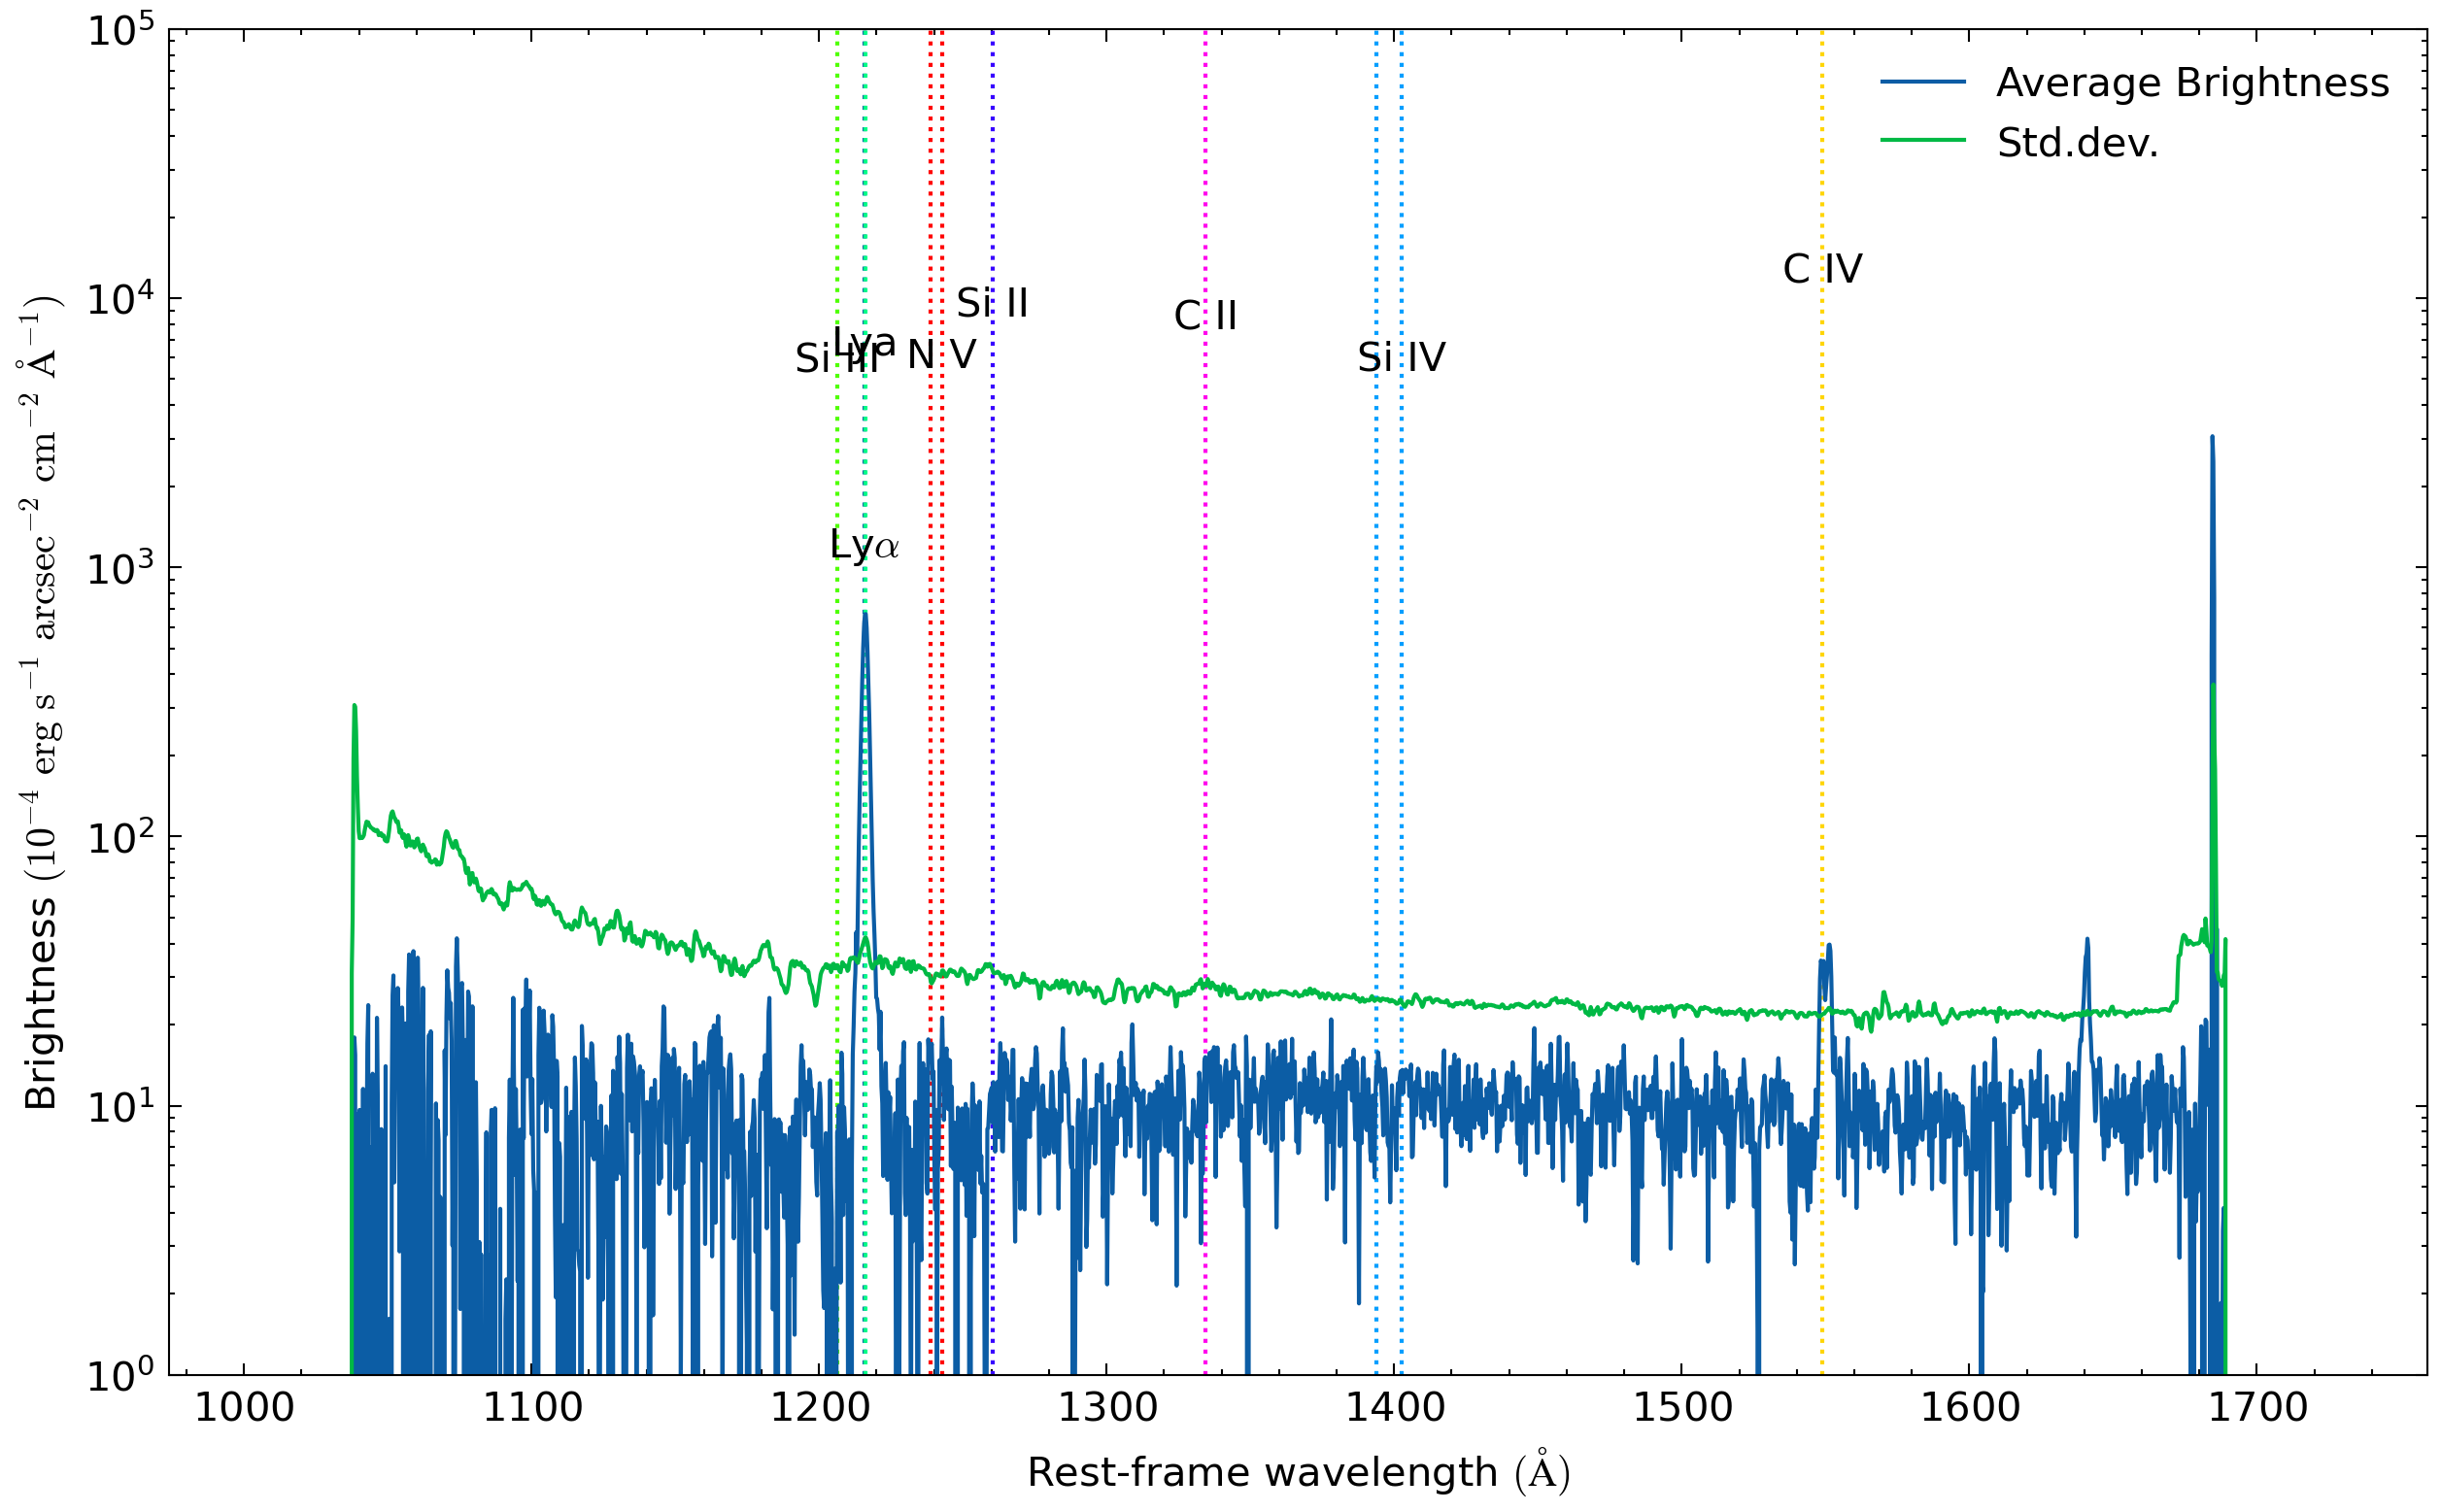

In [174]:
import matplotlib
import scienceplots
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})
rng1 = np.random.default_rng(122807528840384100672342137672332424406)
brighu = r"Brightness $\rm (10^{-4}~erg~s^{-1}~arcsec^{-2}~cm^{-2}~\AA^{-1})$"
fig, ax = plt.subplots(figsize=(10,6),dpi=300)

x = inicube.spectral_axis
xlow=inicube.spectral_extrema[0].value/(1+redshift)
xhigh=inicube.spectral_extrema[1].value/(1+redshift)
keys=lines.keys()
colors=matplotlib.cm.hsv(np.arange(len(keys))/len(keys))

#Marking the important lines
ax.axvline(1215.67,ls=":")
ax.text(1215.67, 1e3,r"Ly$\alpha$",verticalalignment='bottom',horizontalalignment='center',fontsize=10)
mask=np.full(len(x),False)
dlam=7.5/2800
for ind,key in enumerate(keys):
    for line in lines[key]:
        if line < xhigh and line > xlow:
            ax.axvline(line,ls=":",c=colors[ind])
#            masktmp = (x.value < ((1+redshift)*line*(1+dlam))) & (x.value > ((1+redshift)*line*(1-dlam)))
#            mask= mask | masktmp
           # print(x[mask])
    if line < xhigh and line > xlow:
        ax.text(line, 5e3+10**(4*rng1.random()),key,verticalalignment='bottom',horizontalalignment='center',fontsize=10)

ax.plot(x[~mask]/(1+redshift), 1e4*spec[~mask], label = "Average Brightness")
#ax.fill_between(x.value/(1+redshift), spec.value - sigma, spec.value + sigma, color='cyan', alpha=0.2, label='1-sigma region')
ax.plot(x[~mask]/(1+redshift), 1e4*sigma[~mask], label = "Std.dev.")

ax.legend()
ax.set_xlabel(r"Rest-frame wavelength $(\rm \AA)$")
ax.set_ylabel(brighu)
plt.ylim(1, 1e5)
ax.set_xlim([xlow,xhigh])
ax.set_yscale("log")
#fig.savefig("./Q1549-BX101/fig/source_fig.png")

##  calculate the factor and save the corresponding spectrum
The native unit for KCWI data cube is 1e-8 erg/s/arcsec^2/cm^2/cm, which should be converted to Flambda ~ erg/s/cm^2/Angstrom

data was extracted from a circle of 1.8 arsec radius.

In [175]:
# calculate the factor and save the corresponding spectrum
# The native unit for KCWI data cube is 1e-8 erg/s/arcsec^2/cm^2/cm
# which should be converted to Flambda ~ erg/s/cm^2/Angstrom
S=np.pi*(1.8*u.arcsec)**2*1e-8

factor=S/(u.AA/u.cm*u.cm.to(u.AA))
np.savetxt(datapath+"/kcwi_oned/"+sourcename+"_KCWI_cen_spec.txt",np.array([x[~mask],spec[~mask]*factor,sigma[~mask]*factor]).T)

# Derivation of Lya line map

This block use LM least square algorithm to derive the Lya line map in the extended Lya plume

The plume region was selected with single peak criteria. With designated peak prominence, it is possible to determine the position and number of peaks in 1-D spectra.

The prominence of a peak measures how much a peak stands out from the surrounding baseline of the signal and is defined as the vertical distance between the peak and its lowest contour line.

In [15]:
# Initialize fitter
fitter = fitting.LevMarLSQFitter()
# Initialize storage for fit results
line_centers = np.empty(sub_cube2.shape[1:3])
line_widths = np.empty(sub_cube2.shape[1:3])
amplitudes = np.empty(sub_cube2.shape[1:3])

line_centers.fill(np.nan)
line_widths.fill(np.nan)
amplitudes.fill(np.nan)

line_centers0 = np.empty(sub_cube2.shape[1:3])
line_widths0 = np.empty(sub_cube2.shape[1:3])
amplitudes0 = np.empty(sub_cube2.shape[1:3])

line_centers0.fill(np.nan)
line_widths0.fill(np.nan)
amplitudes0.fill(np.nan)

line_centers1 = np.empty(sub_cube2.shape[1:3])
line_widths1 = np.empty(sub_cube2.shape[1:3])
amplitudes1 = np.empty(sub_cube2.shape[1:3])

line_centers1.fill(np.nan)
line_widths1.fill(np.nan)
amplitudes1.fill(np.nan)

# Define the spectral axis (e.g., in Angstrom)
# This should be defined based on the WCS of your cube
spectral_axis = sub_cube2.spectral_axis


for i in range(sub_cube2.shape[1]):
    for j in range(sub_cube2.shape[2]):
        spectrum = sub_cube2[:, i, j]
        var = sub_varcube2[:, i, j]
        var[var==0.0] = 0.1*var.unit
        # Define and fit the model (e.g., Gaussian)
        _,med,std=sigma_clipped_stats(spectrum)
        stdm=np.mean(np.sqrt(var))
        fp = find_peaks(spectrum,prominence=(stdm.value, None))
        
        if len(fp[0]) == 0:
            line_centers[i, j] = np.nan
            line_widths[i, j] = np.nan
            amplitudes[i, j] = np.nan
            line_centers0[i, j] = np.nan
            line_widths0[i, j] = np.nan
            amplitudes0[i, j] = np.nan
            line_centers1[i, j] = np.nan
            line_widths1[i, j] = np.nan
            amplitudes1[i, j] = np.nan
            #print("no peak detected at(",i,j,")")
            continue
        if len(fp[0]) > 1:
            #print("At",i,j)
            #print("There are ",len(fp[0]),"peaks")
            g_init = models.Gaussian1D(amplitude=spectrum.max(), mean=spectral_axis[fp[0][0]], stddev=100.*spectral_axis.unit)
            g_init += models.Gaussian1D(amplitude=spectrum.max(), mean=spectral_axis[fp[0][1]], stddev=100.*spectral_axis.unit)
            g_fit = fitter(g_init, spectral_axis, spectrum, weights=1.0/var)
            line_centers0[i, j] = g_fit.mean_0.value
            line_widths0[i, j] = g_fit.stddev_0.value
            amplitudes0[i, j] = g_fit.amplitude_0.value
            line_centers1[i, j] = g_fit.mean_1.value
            line_widths1[i, j] = g_fit.stddev_1.value
            amplitudes1[i, j] = g_fit.amplitude_1.value
            line_centers[i, j] = np.nan
            line_widths[i, j] = np.nan
            amplitudes[i, j] = np.nan
        else:
            #print("At",i,j)
            #print("There are ",len(fp[0]),"peaks")
            g_init = models.Gaussian1D(amplitude=spectrum.max(), mean=spectral_axis[fp[0][0]], stddev=100.*spectral_axis.unit)
            g_fit = fitter(g_init, spectral_axis, spectrum, weights=1.0/var)
            line_centers[i, j] = g_fit.mean.value
            line_widths[i, j] = g_fit.stddev.value
            amplitudes[i, j] = g_fit.amplitude.value
            line_centers0[i, j] = np.nan
            line_widths0[i, j] = np.nan
            amplitudes0[i, j] = np.nan
            line_centers1[i, j] = np.nan
            line_widths1[i, j] = np.nan
            amplitudes1[i, j] = np.nan
#        g_init += models.PowerLaw1D(amplitude=spectrum.min(),x_0=0.*spectral_axis.unit,alpha=0.1)
        

        # Store the fit results


[-1.50982086e-03 -7.17789579e-04 -5.54686545e-05  1.76554989e-05
 -5.39590498e-04 -1.00508655e-04 -3.97899150e-04 -4.50576880e-04
  1.73106907e-04  7.70126806e-04  2.21650160e-04  1.38967962e-04
  3.79399156e-05  5.68874658e-05  6.23695030e-04 -1.11243207e-04
 -1.65419672e-04 -9.73357744e-05 -6.01271762e-04 -1.10191263e-04
 -3.15044900e-05 -9.61645996e-04 -1.20838967e-03 -6.03368083e-04
 -2.16185209e-04 -7.03694436e-05 -1.30816234e-04 -1.64598713e-04
 -8.54482002e-04 -8.22695354e-05 -2.31065396e-04 -2.82937041e-04
  5.09307501e-04  3.86663284e-04  2.55933677e-04 -8.29524407e-05
 -1.41519065e-05 -7.25223227e-04 -2.05203140e-04  4.65068204e-04
 -1.28477696e-04  6.56215690e-04  1.42587017e-03  4.09881040e-04
  4.05742839e-04  8.89888540e-05 -4.15523515e-04 -4.29161513e-04
  7.53493060e-04  6.36959924e-04  5.31775523e-04  3.83609695e-04
 -3.61041412e-04 -7.99944832e-04  1.15276598e-04  7.16838219e-04
  4.22555488e-04  3.23873827e-04  5.05497155e-04  5.12215682e-04
  7.26609272e-04  2.61108

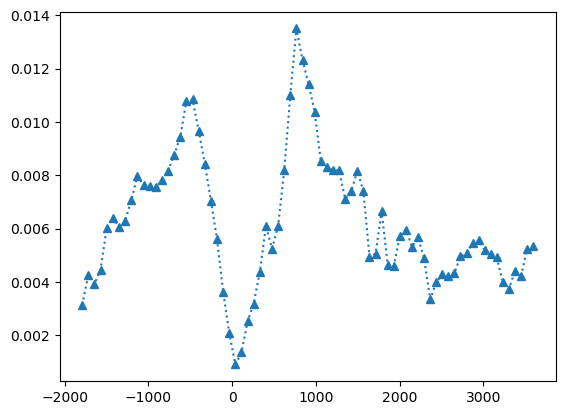

In [16]:
i=15
j=9
print(spectrum)
kernel = Gaussian1DKernel(2)
new_cube = sub_cube2[:, i, j].spectral_smooth(kernel)
plt.plot(sub_cube2.spectral_axis,sub_cube2[:,i,j],"^:")
#plt.plot(spectral_axis,1e-7/var)


In [17]:
stdm=np.mean(np.sqrt(sub_varcube2[:,i,j]))
_,med,std=sigma_clipped_stats(sub_cube2[:, i, j])
fp=find_peaks(sub_cube2[:, i, j],prominence=(med.value+5*std.value, None))
print(fp)


(array([], dtype=int64), {'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)})


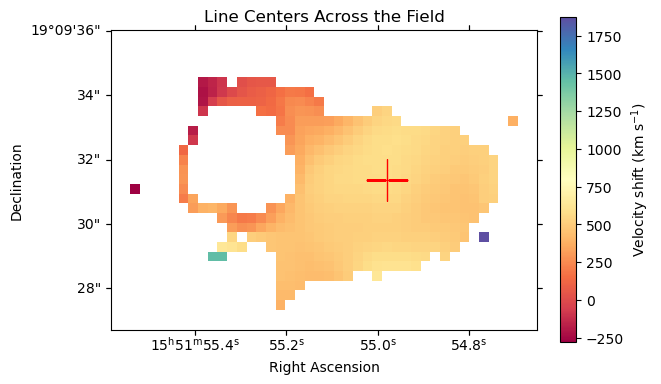

In [18]:
plt.close()
i=15
j=28
linthresh = 1.0

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=spat_wcs)
norm = SymLogNorm(vmin=-5000,vmax=5000,linthresh = linthresh)
im = ax.imshow(line_centers,cmap='Spectral')#,norm=norm)
#im0 = ax.imshow(line_centers0,cmap='PiYG',norm=norm)
#im1 = ax.imshow(line_centers1,cmap='PiYG',norm=norm)
cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)
ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
#kernel = Gaussian1DKernel(2)
spectrum = sub_cube2[:, i, j]#.spectral_smooth(kernel)
ax.plot(j,i,"+",c="r",ms=30,lw=0.1)
plt.title('Line Centers Across the Field')
#plt.colorbar(label='Velocity (km/s)')
plt.show()

0.00432275122106783 1e-08 erg / (arcsec2 cm3 s)
(array([33]), {'prominences': array([0.00761106]), 'left_bases': array([3]), 'right_bases': array([69])})
nan
621.4075789327807 km / s


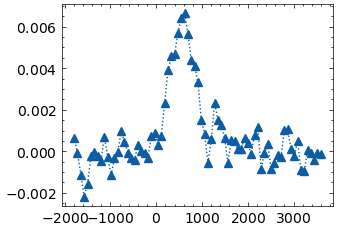

In [92]:

stdm=np.mean(np.sqrt(sub_varcube2[:,i,j]))
kernel = Gaussian1DKernel(2)
new_cube = spectrum.spectral_smooth(kernel)
_,med,std=sigma_clipped_stats(spectrum)
plt.plot(new_cube.spectral_axis,spectrum,"^:")
#plt.plot(spectral_axis[33],spectrum[28],"*")
fp = find_peaks(spectrum,prominence=(stdm.value, None))
print(stdm)
print(fp)
print(line_centers1[i,j])
print(spectral_axis[fp[0][0]])

In [23]:

#Image generation
rest_wavelength=1218. * u.AA # Ly-alpha line
desired_wavelength = rest_wavelength * (redshift+1)
delta=5*u.AA
kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
plotcube = inicube.spectral_slab((desired_wavelength-delta), (desired_wavelength+delta))
plotcube = plotcube.spatial_smooth(kernel)
wcsinfo=iniwcs


# Find the channel index closest to the desired wavelength:
channel_index = (abs(plotcube.spectral_axis - desired_wavelength)).argmin()

#Generating summed image
spec_width = plotcube.spectral_axis[1] - plotcube.spectral_axis[0]
img=(plotcube*spec_width).sum(axis = 0, how = 'cube')

# Spatial slice
testslice = plotcube[channel_index,:, :]
reprojected_linec, _ = reproject_interp((line_centers, spat_wcs), wcsinfo, testslice.shape)
reprojected_linec0, _ = reproject_interp((line_centers0, spat_wcs), wcsinfo, testslice.shape)
reprojected_linec1, _ = reproject_interp((line_centers1, spat_wcs), wcsinfo, testslice.shape)

#
slicev=img.value*1e4
_, med, std = sigma_clipped_stats(slicev)



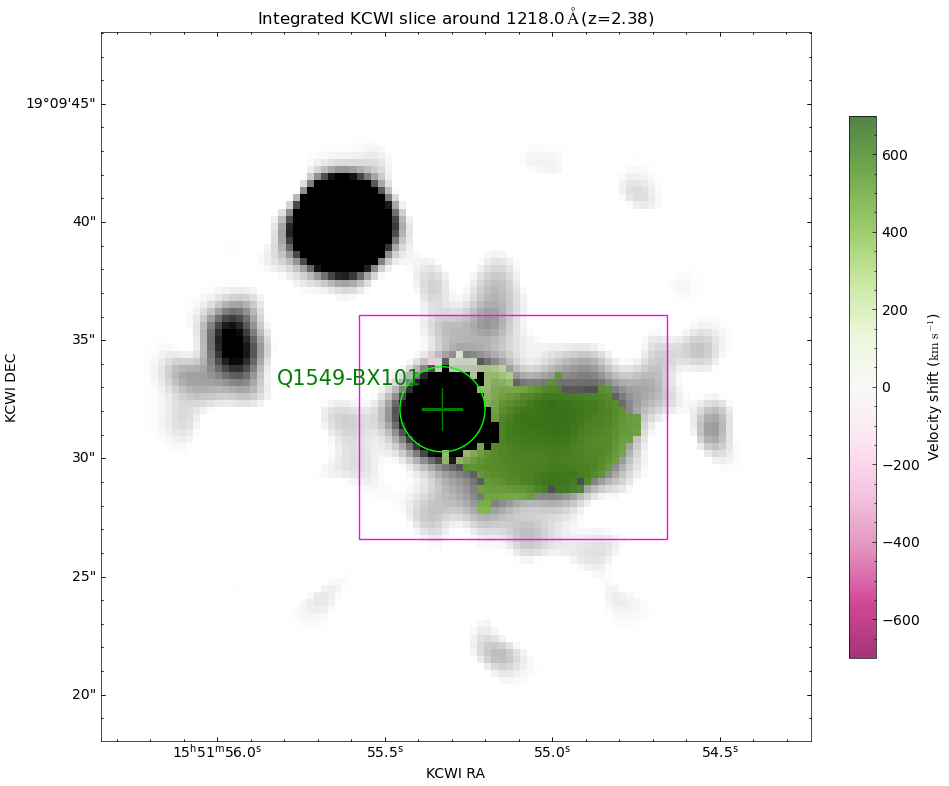

In [24]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})


# Integrated Lya image
fig, ax = imshow_astro(slicev, wcsinfo, cblabel = brightu, colorbar=False, vrange = (med, med+10*std),cmap = "binary")

# Lya velocity map
cmap = plt.cm.PiYG
cmap.set_bad(color='none') 
alpha=0.8
vmin=-700
vmax=700
#norm = SymLogNorm(vmin=-4000,vmax=4000,linthresh = linthresh)
im = ax.imshow(reprojected_linec,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)
#im0 = ax.imshow(reprojected_linec0,cmap=cmap,norm=norm,alpha=alpha)
#im1 = ax.imshow(reprojected_linec1,cmap=cmap,norm=norm,alpha=alpha)
cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)

#Source position
sc = SkyCoord(ra=237.98053, dec=19.15891, unit='deg',frame=FK5, equinox='J2000')
s_coord=wcsinfo.world_to_pixel(sc)
ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)
ax.text(s_coord[0]-3,s_coord[1]+3,"Q1549-BX101",color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)

x0, y0 = 85, 85
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='white', label='North')
ax.text(x0-2, y0+1, 'N', color='white', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='white', label='East')
ax.text(x0+2, y0-1, 'E', color='white', ha='center', va='top')

for r in rl:
    r[0].plot(origin=(0, 0),ax=ax)

#-------------------Reference scale setting----------------#
dT = 50  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = spat_wcs.pixel_to_world(start_x, start_y)
end_coord = spat_wcs.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='white', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='white', ha='center', va='bottom')



ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$(z={})".format(round(rest_wavelength.value,1),round(redshift,2)))
plt.show()

In [30]:
print(delta_ra_per_pixel*3600)
wcsinfo.pixel_scale_matrix[0,0] * 3600

0.31758946632862717


-0.2999999999999988

# Derivation of He II line map
With the same method, I can obtain the feature of important lines. Let's deal with He II 1640.47

In [6]:
#Image generation
rest_wavelength=1640.47 * u.AA # He II line
desired_wavelength = rest_wavelength * (redshift+1)
delta=3*u.AA
kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
plotcube = inicube.spectral_slab((desired_wavelength-delta), (desired_wavelength+delta))
plotcube = plotcube.spatial_smooth(kernel)
wcsinfo=iniwcs


# Find the channel index closest to the desired wavelength:
#channel_index = (abs(plotcube.spectral_axis - desired_wavelength)).argmin()

#Generating summed image
spec_width = plotcube.spectral_axis[1] - plotcube.spectral_axis[0]
img=(plotcube*spec_width).sum(axis = 0, how = 'cube')

# Spatial slice

slicev=img.value*1e4
_, med, std = sigma_clipped_stats(slicev)
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})


# Integrated Lya image
fig, ax = imshow_astro(slicev, wcsinfo, cblabel = brightu, colorbar=False, vrange = (med, med+10*std),cmap = "hot")

# Lya velocity map
"""
cmap = plt.cm.PiYG
cmap.set_bad(color='none') 
alpha=0.8
vmin=-700
vmax=700
#norm = SymLogNorm(vmin=-4000,vmax=4000,linthresh = linthresh)
im = ax.imshow(reprojected_linec,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)
#im0 = ax.imshow(reprojected_linec0,cmap=cmap,norm=norm,alpha=alpha)
#im1 = ax.imshow(reprojected_linec1,cmap=cmap,norm=norm,alpha=alpha)
cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)
"""
#Source position
sc=[]
sc.append(SkyCoord(ra=237.98053, dec=19.15891, unit='deg',frame=FK5, equinox='J2000'))
sc.append(SkyCoord(ra=237.99199, dec=19.20723, unit='deg',frame=FK5, equinox='J2000'))
sc.append(SkyCoord(ra=237.96366, dec=19.18492, unit='deg',frame=FK5, equinox='J2000'))
sc.append(SkyCoord(ra=237.96474, dec=19.18521, unit='deg',frame=FK5, equinox='J2000'))
sc.append(SkyCoord(ra=237.97402, dec=19.18614, unit='deg',frame=FK5, equinox='J2000'))

sname=["BX101", "GNB4950", "M15", "MD10", "MD17"]

#for sind,s in enumerate(sc):
#    s_coord=wcsinfo.world_to_pixel(s)
#    ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)
#    ax.text(s_coord[0]-3,s_coord[1]+3,sname[sind],color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)

sind=0
s_coord=wcsinfo.world_to_pixel(sc[sind])
ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)
ax.text(s_coord[0]-3,s_coord[1]+3,sname[sind],color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)
x0, y0 = 85, 85
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='white', label='North')
ax.text(x0-2, y0+1, 'N', color='white', ha='center', va='bottom')

# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='white', label='East')
ax.text(x0+2, y0-1, 'E', color='white', ha='center', va='top')

regions_str3 = '# Region file format: DS9\nimage\nbox(47.674132,46.660185,31.964647,30.057983,0) # color=magenta\n'
r3 = Regions.parse(regions_str3, format='ds9')
r3[0].plot(origin=(0, 0),ax=ax)
rl[0][0].plot(origin=(0, 0),ax=ax)
#for r in rl:
    #r[0].plot(origin=(-1, -1),ax=ax)

#-------------------Reference scale setting----------------#
dT = 50  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = spat_wcs.pixel_to_world(start_x, start_y)
end_coord = spat_wcs.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='white', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='white', ha='center', va='bottom')



ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$(z={})".format(round(rest_wavelength.value,1),round(redshift,2)))
plt.show()


NameError: name 'redshift' is not defined

### The integrated He II map shows a different spatial distribution in compare with Lya emission.
* The emissions are clustered around north west of the QSO
* We can Narrow the source extraction region to a smaller rectangle 

Now do the spectrum extraction from the new region an look into the He II velocity map

In [763]:
redshift = 2.3806  # BX101

line=1640.47 # He II 2D 5/2 --> 2P 3/2 transition
cube = inicube.subcube_from_regions(r3)
varcube = inivarcube.subcube_from_regions(r3)
spat_wcs = cube.wcs.celestial
sub_cube = cube.spectral_slab(1635*u.AA*(1+redshift), 1645*u.AA*(1+redshift))
sub_varcube = varcube.spectral_slab(1635*u.AA*(1+redshift), 1645*u.AA*(1+redshift))

sub_varcube2 = sub_varcube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=line*(1+redshift) * u.AA)
sub_cube2 = sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=line*(1+redshift) * u.AA)

kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
sub_varcube2 = sub_varcube2.spatial_smooth(kernel)
sub_cube2 = sub_cube2.spatial_smooth(kernel)

In [764]:
# Initialize fitter
fitter = fitting.LevMarLSQFitter()
# Initialize storage for fit results
line_centers = np.empty(sub_cube2.shape[1:3])
line_widths = np.empty(sub_cube2.shape[1:3])
amplitudes = np.empty(sub_cube2.shape[1:3])

line_centers.fill(np.nan)
line_widths.fill(np.nan)
amplitudes.fill(np.nan)

line_centers0 = np.empty(sub_cube2.shape[1:3])
line_widths0 = np.empty(sub_cube2.shape[1:3])
amplitudes0 = np.empty(sub_cube2.shape[1:3])

line_centers0.fill(np.nan)
line_widths0.fill(np.nan)
amplitudes0.fill(np.nan)

line_centers1 = np.empty(sub_cube2.shape[1:3])
line_widths1 = np.empty(sub_cube2.shape[1:3])
amplitudes1 = np.empty(sub_cube2.shape[1:3])

line_centers1.fill(np.nan)
line_widths1.fill(np.nan)
amplitudes1.fill(np.nan)

# Define the spectral axis (e.g., in Angstrom)
# This should be defined based on the WCS of your cube
spectral_axis = sub_cube2.spectral_axis


for i in range(sub_cube2.shape[1]):
    for j in range(sub_cube2.shape[2]):
        spectrum = sub_cube2[:, i, j]
        var = sub_varcube2[:, i, j]
        var[var==0.0] = 0.1*var.unit
        # Define and fit the model (e.g., Gaussian)
        _,med,std=sigma_clipped_stats(spectrum)
        stdm=np.median(np.sqrt(var))
        fp = find_peaks(spectrum,prominence=(stdm.value, None))
        
        if len(fp[0]) == 0:
            g_init = models.Const1D(amplitude=spectrum.max()*0.1)
            g_fit = fitter(g_init, spectral_axis, spectrum, weights=1.0/var)
            line_centers[i, j] = np.nan
            line_widths[i, j] = np.nan
            amplitudes[i, j] = np.nan
            line_centers0[i, j] = np.nan
            line_widths0[i, j] = np.nan
            amplitudes0[i, j] = g_fit.amplitude.value
            line_centers1[i, j] = np.nan
            line_widths1[i, j] = np.nan
            amplitudes1[i, j] = np.nan
            #print("no peak detected at(",i,j,")")
            continue
        else:
            #print("At",i,j)
            #print("There are ",len(fp[0]),"peaks")
            g_init = models.Gaussian1D(amplitude=spectrum.max(), mean=spectral_axis[fp[0][0]], stddev=100.*spectral_axis.unit)
            g_init += models.Const1D(amplitude=spectrum.max()*0.1)
            g_fit = fitter(g_init, spectral_axis, spectrum, weights=1.0/var)
            line_centers[i, j] = g_fit.mean_0.value
            line_widths[i, j] = g_fit.stddev_0.value
            amplitudes[i, j] = g_fit.amplitude_0.value
#            line_centers0[i, j] = np.nan
#            line_widths0[i, j] = np.nan
            amplitudes0[i, j] = g_fit.amplitude_1.value
            line_centers1[i, j] = np.nan
            line_widths1[i, j] = np.nan
            amplitudes1[i, j] = np.nan
#        g_init += models.PowerLaw1D(amplitude=spectrum.min(),x_0=0.*spectral_axis.unit,alpha=0.1)
        

        # Store the fit results


### Test whether the line map has been (at least seemingly) correctly generated 

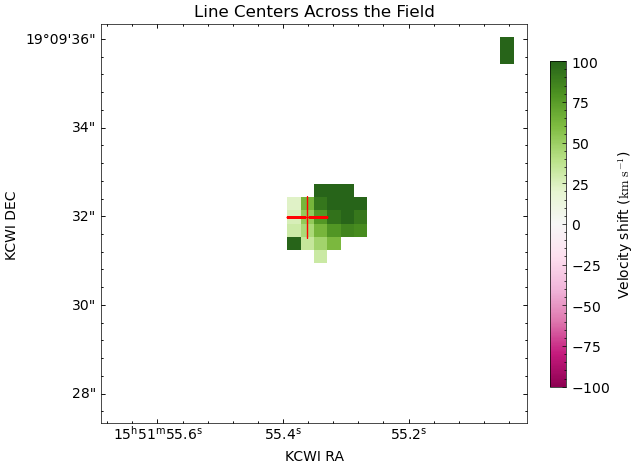

In [787]:
i=15
j=15
linthresh = 1.0

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=spat_wcs)
im = ax.imshow(line_centers,cmap='PiYG',vmin=vmin,vmax=vmax)#,norm=norm)
#im0 = ax.imshow(line_centers0,cmap='PiYG',norm=norm)
#im1 = ax.imshow(line_centers1,cmap='PiYG',norm=norm)
cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)
#ax.coords[0].set_axislabel('Right Ascension')
#ax.coords[1].set_axislabel('Declination')
#kernel = Gaussian1DKernel(2)
spectrum = sub_cube2[:, i, j]#.spectral_smooth(kernel)
ax.plot(j,i,"+",c="r",ms=30,lw=0.1)
plt.title('Line Centers Across the Field')
#plt.colorbar(label='Velocity (km/s)')
plt.show()

0.005436724553639685 1e-08 erg / (arcsec2 cm3 s)
(array([19]), {'prominences': array([0.00703296]), 'left_bases': array([6]), 'right_bases': array([30])})
99.00813094253462 km / s


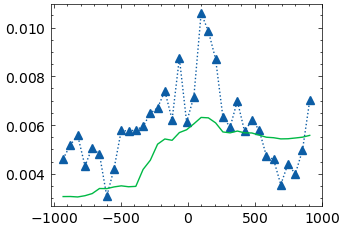

In [788]:
stdm=np.median(np.sqrt(sub_varcube2[:, i, j]))
spectral_axis = sub_cube2.spectral_axis
spectrum = sub_cube2[:, i, j]
plt.plot(spectral_axis,sub_cube2[:, i, j],"^:")
plt.plot(spectral_axis,np.sqrt(sub_varcube2[:, i, j]))
fp = find_peaks(spectrum,prominence=(stdm.value, None))
print(stdm)
print(fp)
print(spectral_axis[fp[0][0]])

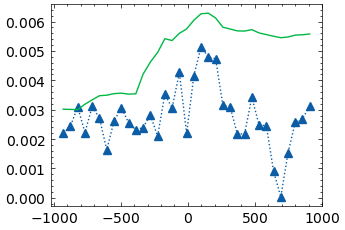

In [650]:
plt.plot(spectral_axis,sub_cube2[:, i, j],"^:")
plt.plot(spectral_axis,np.sqrt(sub_varcube2[:, i, j]))

In [779]:
#Image generation
rest_wavelength=1640.47 * u.AA # He II line
desired_wavelength = rest_wavelength * (redshift+1)
delta=3*u.AA
kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
plotcube = inicube.spectral_slab((desired_wavelength-delta), (desired_wavelength+delta))
plotcube = plotcube.spatial_smooth(kernel)
wcsinfo=iniwcs


# Find the channel index closest to the desired wavelength:
#channel_index = (abs(plotcube.spectral_axis - desired_wavelength)).argmin()

#Generating summed image
spec_width = plotcube.spectral_axis[1] - plotcube.spectral_axis[0]
img=(plotcube*spec_width).sum(axis = 0, how = 'cube')

# Spatial slice
#testslice = plotcube[channel_index,:, :]
reprojected_linec, _ = reproject_interp((line_centers, spat_wcs), wcsinfo, img.shape)
#reprojected_amp0, _ = reproject_interp((amplitudes0, spat_wcs), wcsinfo, testslice.shape) ## continuum level
#reprojected_linec1, _ = reproject_interp((line_centers1, spat_wcs), wcsinfo, testslice.shape)

#
slicev=img.value*1e4
_, med, std = sigma_clipped_stats(slicev)


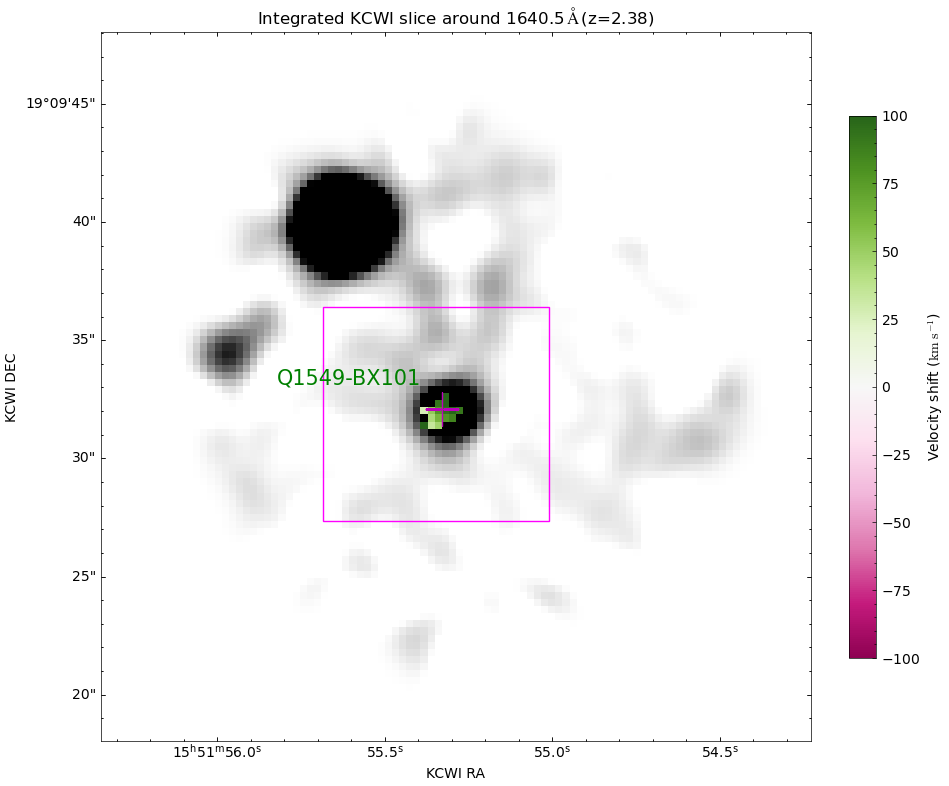

In [780]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})


# Integrated Lya image
fig, ax = imshow_astro(slicev, wcsinfo, cblabel = brightu, colorbar=False, vrange = (med, med+20*std),cmap = "binary")

# He II velocity map

cmap = plt.cm.PiYG
cmap.set_bad(color='none') 
alpha=1.0
vmin=-100
vmax=100
norm = SymLogNorm(vmin=-700,vmax=700,linthresh = linthresh)
im = ax.imshow(reprojected_linec,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)#
#im0 = ax.imshow(reprojected_linec0,cmap=cmap,norm=norm,alpha=alpha)
#im1 = ax.imshow(reprojected_linec1,cmap=cmap,norm=norm,alpha=alpha)
cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)

#Source position
sc = SkyCoord(ra=237.98053, dec=19.15891, unit='deg',frame=FK5, equinox='J2000')
s_coord=wcsinfo.world_to_pixel(sc)
ax.plot(s_coord[0],s_coord[1],"+",c="m",ms=25,lw=0.06)
ax.text(s_coord[0]-3,s_coord[1]+3,"Q1549-BX101",color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)

x0, y0 = 85, 85
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='white', label='North')
ax.text(x0-2, y0+1, 'N', color='white', ha='center', va='bottom')

# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='white', label='East')
ax.text(x0+2, y0-1, 'E', color='white', ha='center', va='top')

regions_str3 = '# Region file format: DS9\nimage\nbox(47.674132,46.660185,31.964647,30.057983,0) # color=magenta\n'
r3 = Regions.parse(regions_str3, format='ds9')
r3[0].plot(origin=(0, 0),ax=ax)
#rl[0][0].plot(origin=(-1, -1),ax=ax)
#for r in rl:
    #r[0].plot(origin=(-1, -1),ax=ax)

#-------------------Reference scale setting----------------#
dT = 50  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = spat_wcs.pixel_to_world(start_x, start_y)
end_coord = spat_wcs.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='white', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='white', ha='center', va='bottom')



ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$(z={})".format(round(rest_wavelength.value,1),round(redshift,2)))
plt.show()


## He II kinematics
* The He II kinematics is comparable to the galactic velocity dispersion, and is mainly in inflowing state. (Hot inflow??)

# Metal absorption line fitting: N V and Silicon
The N V 1238/1242 doublet can be used as density diagnostic and is conseqeuntly important astrophysically.
1. I Redefined the extraction region so as to take the QSO at center.
2. Because I am going to fit the absorption line along quasar sight line, continuum subtraction is needed.

In [93]:
regions_str3 = '# Region file format: DS9\nimage\nbox(48.599999999677834, 47.327999999978545,31.964647,30.057983,0) # color=magenta\n'
r3 = Regions.parse(regions_str3, format='ds9')

## Region define and data read
This time we need to fit both the broad band data (so as to subtract the continuum and Lya profile) and the absorption line.

In [94]:
redshift = 2.3806  # BX101

line=1240. # N V 2P 1/2 --> 2S 1/2 transition doublet
upper=1270.
lower=1199
cube = inicube.subcube_from_regions(r3)
varcube = inivarcube.subcube_from_regions(r3)
spat_wcs = cube.wcs.celestial
sub_cube = cube.spectral_slab(lower*u.AA*(1+redshift), upper*u.AA*(1+redshift))
sub_varcube = varcube.spectral_slab(lower*u.AA*(1+redshift), upper*u.AA*(1+redshift))

#sub_varcube2 = sub_varcube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=line*(1+redshift) * u.AA)
#sub_cube2 = sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=line*(1+redshift) * u.AA)

kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
sub_varcube2 = sub_varcube.spatial_smooth(kernel)
sub_cube2 = sub_cube.spatial_smooth(kernel)

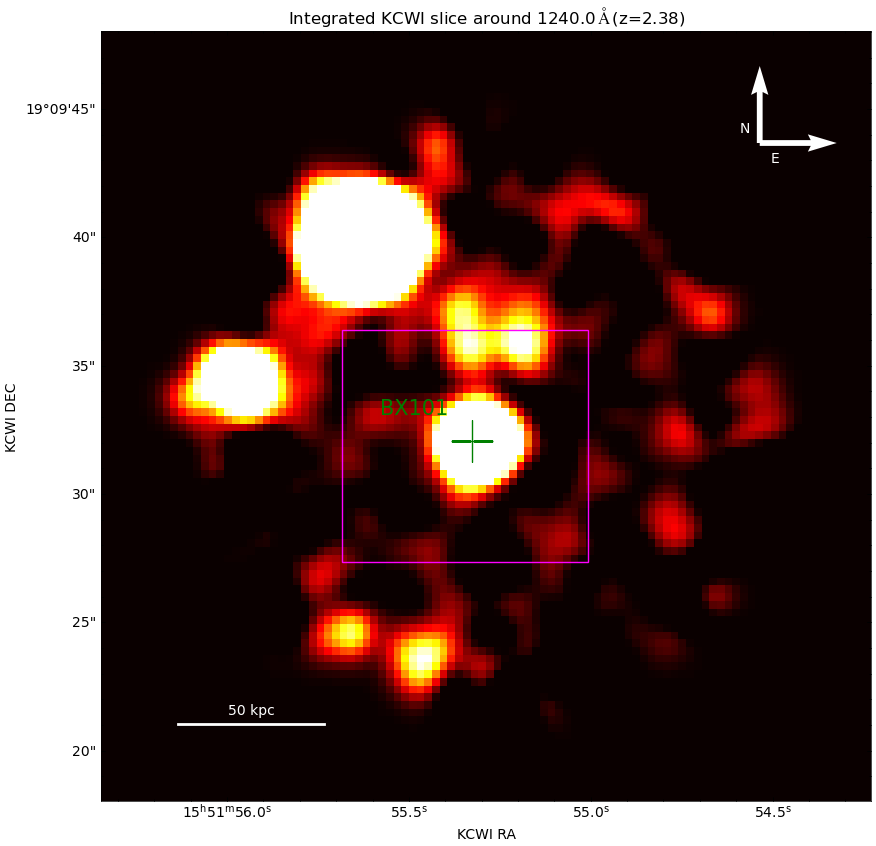

In [95]:
#Image generation
rest_wavelength=1240. * u.AA # He II line
desired_wavelength = rest_wavelength * (redshift+1)
delta=20*u.AA
kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
plotcube = inicube.spectral_slab((desired_wavelength-delta), (desired_wavelength+delta))
plotcube = plotcube.spatial_smooth(kernel)
wcsinfo=iniwcs


# Find the channel index closest to the desired wavelength:
#channel_index = (abs(plotcube.spectral_axis - desired_wavelength)).argmin()

#Generating summed image
spec_width = plotcube.spectral_axis[1] - plotcube.spectral_axis[0]
img=(plotcube*spec_width).sum(axis = 0, how = 'cube')

# Spatial slice

slicev=img.value*1e4
_, med, std = sigma_clipped_stats(slicev)
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})


# Integrated Lya image
fig, ax = imshow_astro(slicev, wcsinfo, cblabel = brightu, colorbar=False, vrange = (med, med+10*std),cmap = "hot")

# Lya velocity map
"""
cmap = plt.cm.PiYG
cmap.set_bad(color='none') 
alpha=0.8
vmin=-700
vmax=700
#norm = SymLogNorm(vmin=-4000,vmax=4000,linthresh = linthresh)
im = ax.imshow(reprojected_linec,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)
#im0 = ax.imshow(reprojected_linec0,cmap=cmap,norm=norm,alpha=alpha)
#im1 = ax.imshow(reprojected_linec1,cmap=cmap,norm=norm,alpha=alpha)
cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)
"""
#Source position
sc=[]
sc.append(SkyCoord(ra=237.98053, dec=19.15891, unit='deg',frame=FK5, equinox='J2000'))
sc.append(SkyCoord(ra=237.99199, dec=19.20723, unit='deg',frame=FK5, equinox='J2000'))
sc.append(SkyCoord(ra=237.96366, dec=19.18492, unit='deg',frame=FK5, equinox='J2000'))
sc.append(SkyCoord(ra=237.96474, dec=19.18521, unit='deg',frame=FK5, equinox='J2000'))
sc.append(SkyCoord(ra=237.97402, dec=19.18614, unit='deg',frame=FK5, equinox='J2000'))

sname=["BX101", "GNB4950", "M15", "MD10", "MD17"]

#for sind,s in enumerate(sc):
#    s_coord=wcsinfo.world_to_pixel(s)
#    ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)
#    ax.text(s_coord[0]-3,s_coord[1]+3,sname[sind],color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)

sind=0
s_coord=wcsinfo.world_to_pixel(sc[sind])
ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)
ax.text(s_coord[0]-3,s_coord[1]+3,sname[sind],color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)
x0, y0 = 85, 85
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='white', label='North')
ax.text(x0-2, y0+1, 'N', color='white', ha='center', va='bottom')

# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='white', label='East')
ax.text(x0+2, y0-1, 'E', color='white', ha='center', va='top')

regions_str3 = '# Region file format: DS9\nimage\nbox(47.674132,46.660185,31.964647,30.057983,0) # color=magenta\n'
r3 = Regions.parse(regions_str3, format='ds9')
r3[0].plot(origin=(0, 0),ax=ax)
#for r in rl:
    #r[0].plot(origin=(-1, -1),ax=ax)

#-------------------Reference scale setting----------------#
dT = 50  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = spat_wcs.pixel_to_world(start_x, start_y)
end_coord = spat_wcs.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='white', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='white', ha='center', va='bottom')



ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$(z={})".format(round(rest_wavelength.value,1),round(redshift,2)))
plt.show()


* Initial examination shows that the quasar sight line is dominated by double peaked Ly alpha emissions and N V doublet absorption.
* There is an extra 1206.5 \AA absorption of unclear origin. My guess is Si III. The transition probability looks quite large, but I am not sure whether the metalicity in high z quasar can support such a strong line. 

0.004361562583354534 1e-08 erg / (arcsec2 cm3 s)
(array([ 20,  48,  67, 147, 157]), {'prominences': array([0.00462123, 0.02355299, 0.0278758 , 0.00552806, 0.00826378]), 'left_bases': array([  4,  26,  57, 138, 138]), 'right_bases': array([ 26,  57, 138, 151, 209])})
[1204.81571319 1213.09826658 1218.71857067 1242.38300893 1245.34106372] Angstrom


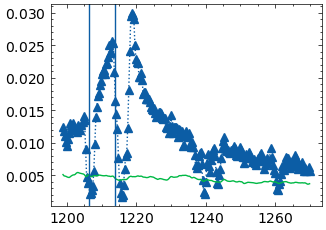

In [97]:
i,j=(15,15)
stdm=np.median(np.sqrt(sub_varcube2[:, i, j]))
spectral_axis = sub_cube2.spectral_axis
spectrum = sub_cube2[:, i, j]
plt.plot(spectral_axis/(1+redshift),sub_cube2[:, i, j],"^:")
plt.plot(spectral_axis/(1+redshift),np.sqrt(sub_varcube2[:, i, j]))
plt.axvline(1206.5) # Si III ???
plt.axvline(1213.809)
fp = find_peaks(spectrum,prominence=(stdm.value, None))
print(stdm)
print(fp)
print(spectral_axis[fp[0]]/(1+redshift))

I am going to fit 6 gaussian lines to this profile. This time I will do this in wavelength space rather than velocity space.

In [98]:
# Initialize fitter
fitter = fitting.LevMarLSQFitter()

nlines=7 #how many lines do you want to fit?
# Initialize storage for fit results
line_centers = np.empty((nlines,*sub_cube2.shape[1:3]))
line_widths = np.empty((nlines,*sub_cube2.shape[1:3]))
amplitudes = np.empty((nlines+1,*sub_cube2.shape[1:3]))


line_centers.fill(np.nan)
line_widths.fill(np.nan)
amplitudes.fill(np.nan)

linecent = np.array([1206.5,1238.,1242.,1260.42])*u.AA #Si III, N V doublet, Si II
lineamp = np.array([-0.02,-0.01,-0.01,-0.02])*spectrum.unit
# Define the spectral axis (e.g., in Angstrom)
# This should be defined based on the WCS of your cube
spectral_axis = sub_cube2.spectral_axis/(1+redshift)

fitted_y = np.empty((*sub_cube2.shape[1:3],spectral_axis.shape[0]))
for i in range(sub_cube2.shape[1]):
    for j in range(sub_cube2.shape[2]):
        spectrum = sub_cube2[:, i, j]
        var = sub_varcube2[:, i, j]
        var[var==0.0] = 0.1*var.unit
        # Define and fit the model (e.g., Gaussian)
        stdm=np.median(np.sqrt(var))
        fp = find_peaks(spectrum,prominence=(stdm.value, None))
        
        if len(fp[0]) != 0:
            # three lines to characterize Ly alpha
            g_init = models.Gaussian1D(amplitude=spectrum.max(), mean=1213.809*u.AA, stddev=3*u.AA)
            g_init += models.Gaussian1D(amplitude=spectrum.max(), mean=1218.344*u.AA, stddev=1*u.AA)
            g_init += models.Gaussian1D(amplitude=-spectrum.max(), mean=1215.67*u.AA, stddev=1*u.AA)
            for lind, line in enumerate(linecent):
                g_init += models.Gaussian1D(amplitude=lineamp[lind], mean=line, stddev=1*u.AA)
            g_init += models.Const1D(amplitude=spectrum.max()*0.5)
            g_fit = fitter(g_init, spectral_axis, spectrum, weights=1.0/var)
            y_fit = g_fit(spectral_axis)
            fitted_y[i,j,:]=y_fit
            for l in range(nlines):
                line_centers[l, i, j] = getattr(g_fit,"mean_{}".format(l)).value
                line_widths[l, i, j] = getattr(g_fit,"stddev_{}".format(l)).value
                amplitudes[l, i, j] = getattr(g_fit,"amplitude_{}".format(l)).value
            amplitudes[-1, i, j] = getattr(g_fit,"amplitude_{}".format(l+1)).value
#        g_init += models.PowerLaw1D(amplitude=spectrum.min(),x_0=0.*spectral_axis.unit,alpha=0.1)
        

        # Store the fit results


I masked out peaks with amplitude lower than 1/2 of the median standard deviation. This could rule out a great part of the fake detections

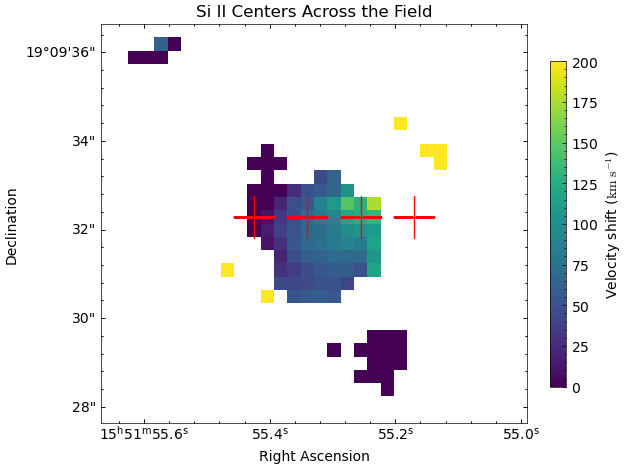

In [99]:
coord=[(15,11),(15,15),(15,19),(15,23)]

linthresh = 1.0

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=spat_wcs)
alpha=0.8
vmin=0
vmax=200


lineind=3

stdm=np.median(np.sqrt(sub_varcube2[:, i, j]))
equi=u.doppler_relativistic(linecent[lineind])
SNmask=np.abs(amplitudes[lineind+3,:,:])<0.5*stdm.value


vshift = (line_centers[lineind+3,:,:]*u.AA).to(u.km/u.s,equivalencies=equi)
amp = amplitudes[lineind+3,:,:]
data_display = np.copy(vshift)
data_display[SNmask] = np.nan * u.km/u.s
linthresh=1
#norm = SymLogNorm(vmin=-3000,vmax=3000,linthresh = linthresh)
im0 = ax.imshow(data_display.value,cmap='viridis',alpha=1,vmin=vmin,vmax=vmax)
#im0 = ax.imshow(data_display,cmap='PiYG',alpha=0.5,vmin=vmin,vmax=vmax)
#im1 = ax.imshow(line_centers[1,:,:],cmap='PiYG',alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)
#im0 = ax.imshow(line_centers0,cmap='PiYG',norm=norm)
#im1 = ax.imshow(line_centers1,cmap='PiYG',norm=norm)

cb = plt.colorbar(im0, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)
#cb = plt.colorbar(im0, label = r"Amplitude", fraction =0.035)

ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
#kernel = Gaussian1DKernel(2)

for i,j in coord:
    ax.plot(j,i,"+",c="r",ms=30,lw=0.1)
plt.title('Si II Centers Across the Field')
#plt.colorbar(label='Velocity (km/s)')
plt.show()

[1216.12557384 1220.0188763  1215.38270937 1206.72861048 1241.88416743
 1240.27862172 1262.83159876]
1262.831598755022
-0.0006162895130387657


Text(0.5, 0, 'Wavelength ($\\AA$)')

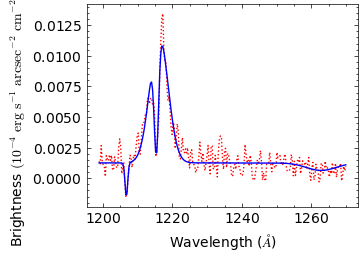

In [209]:
line=1216.56
#sub_cube3 = sub_cube2.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=line*(1+redshift) * u.AA)

i,j=coord[3]
print(line_centers[:,i,j])
print(line_centers[lineind+3,i,j])
print(amplitudes[lineind+3,i,j])
plt.plot(spectral_axis, sub_cube2[:, i, j], "r:")
plt.plot(spectral_axis, fitted_y[i,j,:], "b")
plt.ylabel(brightu)
plt.xlabel(r"Wavelength ($\AA$)")

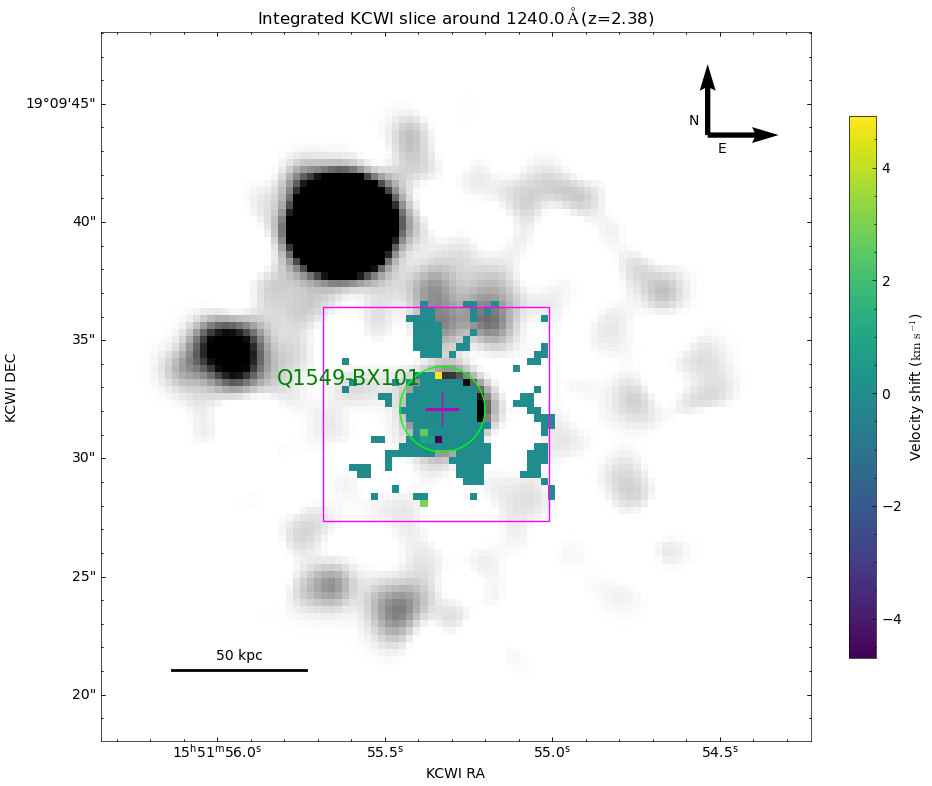

In [66]:
#Image generation
rest_wavelength=1240. * u.AA # He II line
desired_wavelength = rest_wavelength * (redshift+1)
delta=20*u.AA
kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
plotcube = inicube.spectral_slab((desired_wavelength-delta), (desired_wavelength+delta))
plotcube = plotcube.spatial_smooth(kernel)
wcsinfo=iniwcs


# Find the channel index closest to the desired wavelength:
#channel_index = (abs(plotcube.spectral_axis - desired_wavelength)).argmin()

#Generating summed image
spec_width = plotcube.spectral_axis[1] - plotcube.spectral_axis[0]
img=(plotcube*spec_width).sum(axis = 0, how = 'cube')

# Spatial slice
#testslice = plotcube[channel_index,:, :]
reprojected_linec, _ = reproject_interp((data_display, spat_wcs), wcsinfo, img.shape)
#reprojected_amp0, _ = reproject_interp((amplitudes0, spat_wcs), wcsinfo, testslice.shape) ## continuum level
#reprojected_linec1, _ = reproject_interp((line_centers1, spat_wcs), wcsinfo, testslice.shape)

#
slicev=img.value*1e4
_, med, std = sigma_clipped_stats(slicev)


plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})


# Integrated Lya image
fig, ax = imshow_astro(slicev, wcsinfo, cblabel = brightu, colorbar=False, vrange = (med, med+20*std),cmap = "binary")

# He II velocity map

cmap = plt.cm.viridis
cmap.set_bad(color='none') 
alpha=1.0
vmin=0
#vmax=1000
#norm = SymLogNorm(vmin=0,vmax=1000,linthresh = linthresh)
im = ax.imshow(reprojected_linec,cmap=cmap,alpha=alpha)#,vmin=vmin,vmax=vmax)#,norm=norm)
#im0 = ax.imshow(reprojected_linec0,cmap=cmap,norm=norm,alpha=alpha)
#im1 = ax.imshow(reprojected_linec1,cmap=cmap,norm=norm,alpha=alpha)
cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)

#Source position
sc = SkyCoord(ra=237.98053, dec=19.15891, unit='deg',frame=FK5, equinox='J2000')
s_coord=wcsinfo.world_to_pixel(sc)
ax.plot(s_coord[0],s_coord[1],"+",c="m",ms=25,lw=0.06)
ax.text(s_coord[0]-3,s_coord[1]+3,"Q1549-BX101",color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)

x0, y0 = 85, 85
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='k', label='North')
ax.text(x0-2, y0+1, 'N', color='k', ha='center', va='bottom')

# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='k', label='East')
ax.text(x0+2, y0-1, 'E', color='k', ha='center', va='top')

regions_str3 = '# Region file format: DS9\nimage\nbox(47.674132,46.660185,31.964647,30.057983,0) # color=magenta\n'
r3 = Regions.parse(regions_str3, format='ds9')
r3[0].plot(origin=(0, 0),ax=ax)
rl[0][0].plot(origin=(0, 0),ax=ax)
#for r in rl:
    #r[0].plot(origin=(-1, -1),ax=ax)

#-------------------Reference scale setting----------------#
dT = 50  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = spat_wcs.pixel_to_world(start_x, start_y)
end_coord = spat_wcs.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='k', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='k', ha='center', va='bottom')



ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$(z={})".format(round(rest_wavelength.value,1),round(redshift,2)))
plt.show()


This is still an inflowing ion.....

# Metal absorption line fitting: C IV
The C IV 1548.187/1550.772 doublet is also important astrophysically, as an ion characterizing highly ionized species
1. Broad C IV line should be treated

In [106]:
redshift = 2.3806  # BX101

regions_str3 = '# Region file format: DS9\nimage\nbox(48.599999999677834, 47.327999999978545,31.964647,30.057983,0) # color=magenta\n'
r3 = Regions.parse(regions_str3, format='ds9')

line=1549. # C IV 2P --> 2S transition doublet
upper=1480.
lower=1620
cube = inicube.subcube_from_regions(r3)
varcube = inivarcube.subcube_from_regions(r3)
spat_wcs = cube.wcs.celestial
sub_cube = cube.spectral_slab(lower*u.AA*(1+redshift), upper*u.AA*(1+redshift))
sub_varcube = varcube.spectral_slab(lower*u.AA*(1+redshift), upper*u.AA*(1+redshift))

sub_varcube2 = sub_varcube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=line*(1+redshift) * u.AA)
sub_cube2 = sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=line*(1+redshift) * u.AA)

kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
sub_varcube2 = sub_varcube2.spatial_smooth(kernel)
sub_cube2 = sub_cube2.spatial_smooth(kernel)

0.0029991599302256677 1e-08 erg / (arcsec2 cm3 s)
(array([217, 227, 238, 249]), {'prominences': array([0.00908643, 0.00581313, 0.0055501 , 0.01107764]), 'left_bases': array([  0, 225, 235, 235]), 'right_bases': array([235, 235, 243, 435])})
[-254.93261393  -85.21406988  101.10260585  287.02776316] km / s


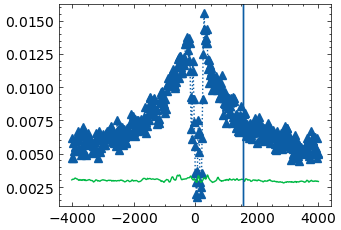

In [107]:
i,j=(15,15)
stdm=np.median(np.sqrt(sub_varcube2[:, i, j]))
spectral_axis = sub_cube2.spectral_axis
spectrum = sub_cube2[:, i, j]
plt.plot(spectral_axis/(1+redshift),sub_cube2[:, i, j],"^:")
plt.plot(spectral_axis/(1+redshift),np.sqrt(sub_varcube2[:, i, j]))
plt.axvline(1548.187)
plt.axvline(1550.772)
fp = find_peaks(spectrum,prominence=(stdm.value, None))
print(stdm)
print(fp)
print(spectral_axis[fp[0]]/(1+redshift))

In [108]:
# Initialize fitter
fitter = fitting.LevMarLSQFitter()

nlines=3 #how many lines do you want to fit?
# Initialize storage for fit results
line_centers = np.empty((nlines,*sub_cube2.shape[1:3]))
line_widths = np.empty((nlines,*sub_cube2.shape[1:3]))
amplitudes = np.empty((nlines+1,*sub_cube2.shape[1:3]))


line_centers.fill(np.nan)
line_widths.fill(np.nan)
amplitudes.fill(np.nan)

linecent = np.array([1548.187,1550.772])*u.AA #Si III, N V doublet, Si II
lineamp = np.array([-0.02,-0.02])*spectrum.unit
# Define the spectral axis (e.g., in Angstrom)
# This should be defined based on the WCS of your cube
spectral_axis = sub_cube2.spectral_axis/(1+redshift)

fitted_y = np.empty((*sub_cube2.shape[1:3],spectral_axis.shape[0]))
for i in range(sub_cube2.shape[1]):
    for j in range(sub_cube2.shape[2]):
        spectrum = sub_cube2[:, i, j]
        var = sub_varcube2[:, i, j]
        var[var==0.0] = 0.1*var.unit
        # Define and fit the model (e.g., Gaussian)
        stdm=np.median(np.sqrt(var))
        fp = find_peaks(spectrum,prominence=(stdm.value, None))
        if len(fp[0]) != 0:
            # two lines to characterize C IV emissions
#            g_init = models.Voigt1D(amplitude_L=spectrum.max(), x_0=0.1*spectral_axis.unit, fwhm_L = 20*spectral_axis.unit, fwhm_G=100*spectral_axis.unit)
            g_init = models.Voigt1D(amplitude_L=spectrum.max(), x_0=0.1*spectral_axis.unit, fwhm_L = 500*spectral_axis.unit, fwhm_G=2000*spectral_axis.unit)
            for lind, line in enumerate(linecent):
                g_init += models.Voigt1D(amplitude_L=lineamp[lind], x_0=0.1*spectral_axis.unit, fwhm_L = 3*spectral_axis.unit, fwhm_G=10*spectral_axis.unit)
            g_init += models.Const1D(amplitude=spectrum.max()*0.5)
            g_fit = fitter(g_init, spectral_axis, spectrum, weights=1.0/var)
            y_fit = g_fit(spectral_axis)
            fitted_y[i,j,:]=y_fit
            for l in range(nlines):
                line_centers[l, i, j] = getattr(g_fit,"x_0_{}".format(l)).value
                line_widths[l, i, j] = getattr(g_fit,"fwhm_G_{}".format(l)).value
                amplitudes[l, i, j] = getattr(g_fit,"amplitude_L_{}".format(l)).value
            amplitudes[-1, i, j] = getattr(g_fit,"amplitude_{}".format(l+1)).value

        # Store the fit results


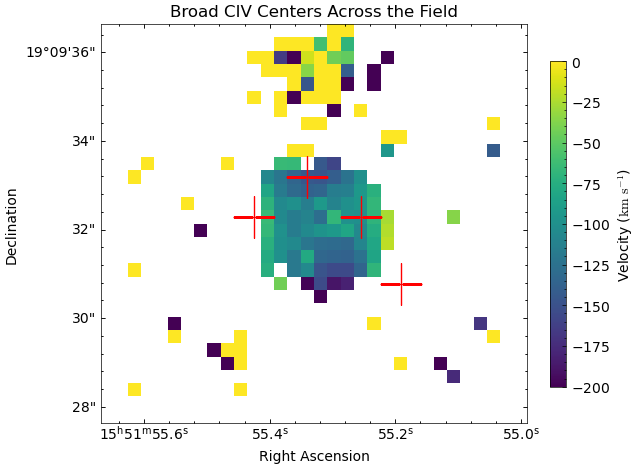

In [134]:
coord=[(15,11),(18,15),(15,19),(10,22)]

linthresh = 1.0

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=spat_wcs)
alpha=0.8
vmin=-200
vmax=0


lineind=0

stdm=np.median(np.sqrt(sub_varcube2[:, i, j]))
#equi=u.doppler_relativistic(linecent[lineind])
SNmask=np.abs(amplitudes[lineind,:,:])<1.*stdm.value


vshift = line_centers[lineind,:,:]
amp = amplitudes[lineind,:,:]
wid = line_widths[lineind,:,:]

data_display = np.copy(vshift)
data_display[SNmask] = np.nan * u.km/u.s

data_display2 = np.copy(wid)
data_display2[SNmask] = np.nan * u.km/u.s

linthresh=1
norm = SymLogNorm(vmin=-10000,vmax=10000,linthresh = linthresh)
im0 = ax.imshow(data_display,cmap='viridis',alpha=1,vmin=vmin,vmax=vmax)
#im0 = ax.imshow(data_display,cmap='PiYG',alpha=0.9,norm=norm)#,vmin=vmin,vmax=vmax)
#im1 = ax.imshow(data_display2,cmap='binary',alpha=1,norm=norm)
#im1 = ax.imshow(line_centers[1,:,:],cmap='PiYG',alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)
#im0 = ax.imshow(line_centers0,cmap='PiYG',norm=norm)
#im1 = ax.imshow(line_centers1,cmap='PiYG',norm=norm)

cb = plt.colorbar(im0, label = r"Velocity ($\rm km~s^{-1}$)", fraction =0.035)
#cb = plt.colorbar(im0, label = r"Amplitude", fraction =0.035)

ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
#kernel = Gaussian1DKernel(2)

for i,j in coord:
    ax.plot(j,i,"+",c="r",ms=30,lw=0.1)
plt.title('Broad CIV Centers Across the Field')
#plt.colorbar(label='Velocity (km/s)')
plt.show()

[-145.30939484    8.13047899    8.13047903]
[2.71047489e+03 4.78141025e-01 4.78141018e-01]
[ 0.00621571 -0.01399478 -0.01399478]
0.0028545228170414496


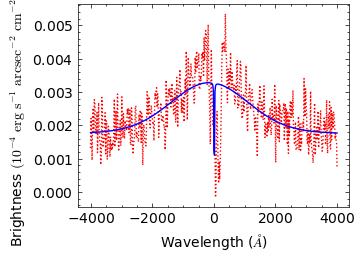

In [133]:

i,j=coord[1]
print(line_centers[:,i,j])
print(line_widths[:,i,j])
print(amplitudes[:-1,i,j])
plt.plot(spectral_axis, sub_cube2[:, i, j], "r:")
plt.plot(spectral_axis, fitted_y[i,j,:], "b")
plt.ylabel(brightu)
plt.xlabel(r"Wavelength ($\AA$)")
print(stdm.value)

## KCWI image with MOSFIRE slit position marked with rectangular

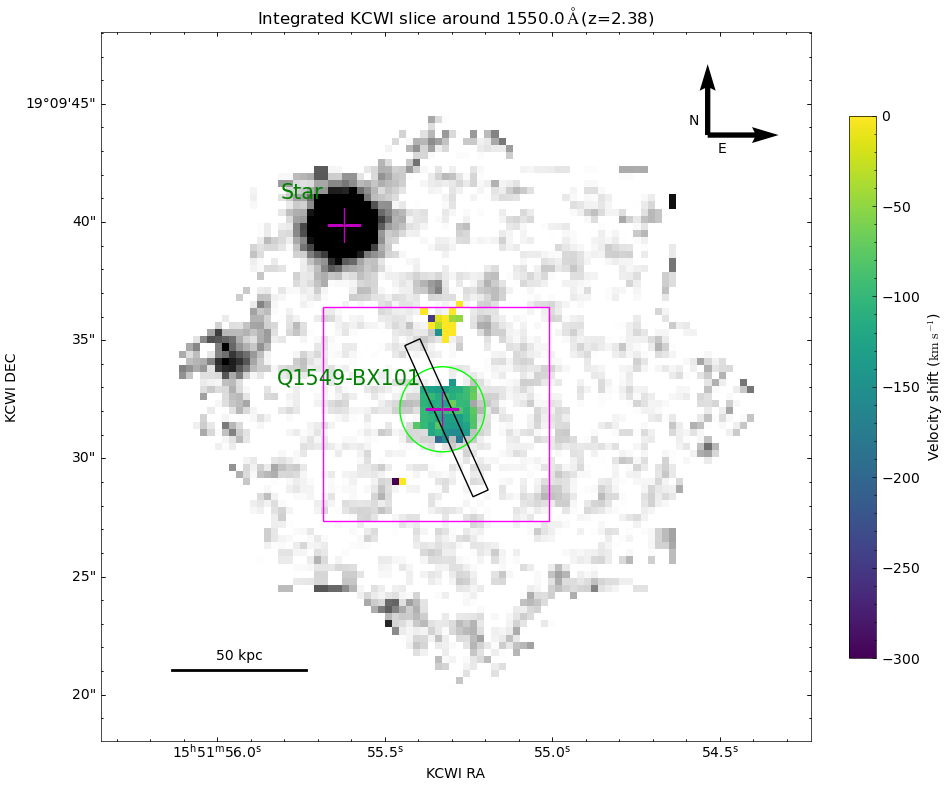

In [155]:
#Image generation
rest_wavelength=1550 * u.AA # He II line
desired_wavelength = rest_wavelength * (redshift+1)
delta=5*u.AA
kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
plotcube = inicube.spectral_slab((desired_wavelength-delta), (desired_wavelength+delta))
#plotcube = plotcube.spatial_smooth(kernel)
wcsinfo=iniwcs


# Find the channel index closest to the desired wavelength:
#channel_index = (abs(plotcube.spectral_axis - desired_wavelength)).argmin()

#Generating summed image
spec_width = plotcube.spectral_axis[1] - plotcube.spectral_axis[0]
img=(plotcube*spec_width).sum(axis = 0, how = 'cube')

# Spatial slice
#testslice = plotcube[channel_index,:, :]
reprojected_linec, _ = reproject_interp((data_display, spat_wcs), wcsinfo, img.shape)
#reprojected_amp0, _ = reproject_interp((amplitudes0, spat_wcs), wcsinfo, testslice.shape) ## continuum level
#reprojected_linec1, _ = reproject_interp((line_centers1, spat_wcs), wcsinfo, testslice.shape)

#
slicev=img.value*1e4
_, med, std = sigma_clipped_stats(slicev)


plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})


# Integrated Lya image
fig, ax = imshow_astro(slicev, wcsinfo, cblabel = brightu, colorbar=False, vrange = (med, med+20*std),cmap = "binary")

# He II velocity map

cmap = plt.cm.viridis
cmap.set_bad(color='none') 
alpha=1.0
vmin=-300
vmax=0
#norm = SymLogNorm(vmin=0,vmax=1000,linthresh = linthresh)
im = ax.imshow(reprojected_linec,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)
#im0 = ax.imshow(reprojected_linec0,cmap=cmap,norm=norm,alpha=alpha)
#im1 = ax.imshow(reprojected_linec1,cmap=cmap,norm=norm,alpha=alpha)
cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)

#Source position
sc = SkyCoord(ra=237.98053, dec=19.15891, unit='deg',frame=FK5, equinox='J2000')
s_coord=wcsinfo.world_to_pixel(sc)
ax.plot(s_coord[0],s_coord[1],"+",c="m",ms=25,lw=0.06)
ax.text(s_coord[0]-3,s_coord[1]+3,"Q1549-BX101",color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)

Starsc = SkyCoord(ra=237.98175, dec=19.16108, unit='deg',frame=FK5, equinox='J2000')
s_coord=wcsinfo.world_to_pixel(Starsc)
ax.plot(s_coord[0],s_coord[1],"+",c="m",ms=25,lw=0.06)
ax.text(s_coord[0]-3,s_coord[1]+3,"Star",color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)


x0, y0 = 85, 85
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='k', label='North')
ax.text(x0-2, y0+1, 'N', color='k', ha='center', va='bottom')

# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='k', label='East')
ax.text(x0+2, y0-1, 'E', color='k', ha='center', va='top')

regions_str3 = '# Region file format: DS9\nimage\nbox(47.674132,46.660185,31.964647,30.057983,0) # color=magenta\n'
r3 = Regions.parse(regions_str3, format='ds9')
r3[0].plot(origin=(0, 0),ax=ax)
rl[0][0].plot(origin=(0, 0),ax=ax)

from regions import RectangleSkyRegion

center_sky = SkyCoord(237.98048,19.15881, unit='deg', frame='fk5')
region_sky4 = RectangleSkyRegion(center=center_sky,
                                 width=0.70000 * u.arcsec, height=7.01458 * u.arcsec,
                                 angle=24.300 * u.deg)

region_pix4 = region_sky4.to_pixel(wcsinfo)
region_pix4.plot(origin=(0, 0),ax=ax)

#for r in rl:
    #r[0].plot(origin=(-1, -1),ax=ax)

#-------------------Reference scale setting----------------#
dT = 50  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = spat_wcs.pixel_to_world(start_x, start_y)
end_coord = spat_wcs.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='k', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='k', ha='center', va='bottom')



ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$(z={})".format(round(rest_wavelength.value,1),round(redshift,2)))
plt.show()


# MOSFIRE spectrum fitting, line identification

In [2]:
# Reading 2D & 1D spectra
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
import scienceplots

import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel
KBSSpath="/disk/bifrost/yuanze/KBSS"
cubename="Q0100"
sourcename="BX172"
redshift=2.3118
datapath=KBSSpath+"/"+cubename+"/"+sourcename

mos2dH = fits.open(datapath+"/mosfire/Q0100msfr3.ws_H_BX172_flx.fits")
#mos2dHsig = fits.open("/disk/bifrost/yuanze/KBSS/Q1549/BX101/mosfire/Q1549close1_H_BX101_flx.sig.fits")
mos1dH = fits.open(datapath+"/mosfire/Q0100msfr3.ws_H_BX172_1d.fits")

ps = mos2dH[0].header["PSCALE"]

mos2dK = fits.open(datapath+"/mosfire/Q0100msfr3.ws_H_BX172_flx.fits")
#mos2dKsig = fits.open("/disk/bifrost/yuanze/KBSS/Q1549/BX101/mosfire/Q1549close1_K_BX101_flx.sig.fits")
mos1dK = fits.open(datapath+"/mosfire/Q0100msfr3.ws_K_BX172_1d.fits")

In [3]:
spec_axisK = mos1dK[0].header["CRVAL1"] + (np.arange(mos1dK[0].data.shape[1])+1)*mos1dK[0].header["CD1_1"]
spec_axisH = mos1dH[0].header["CRVAL1"] + (np.arange(mos1dH[0].data.shape[1])+1)*mos1dH[0].header["CD1_1"]
flux_1dH = mos1dH[0].data[0]
flux_1dK = mos1dK[0].data[0]
maskH = np.abs(mos1dH[0].data[2]) < 0.1
maskK = np.abs(mos1dK[0].data[2]) < 0.1

In [4]:
lines={'[N II]':[6548.,6583.],"[S II]":[6716.,6731.] ,'[O III]':[4959,5007], r"H$\alpha$":[6563], r"H$\beta$":[4861.]}

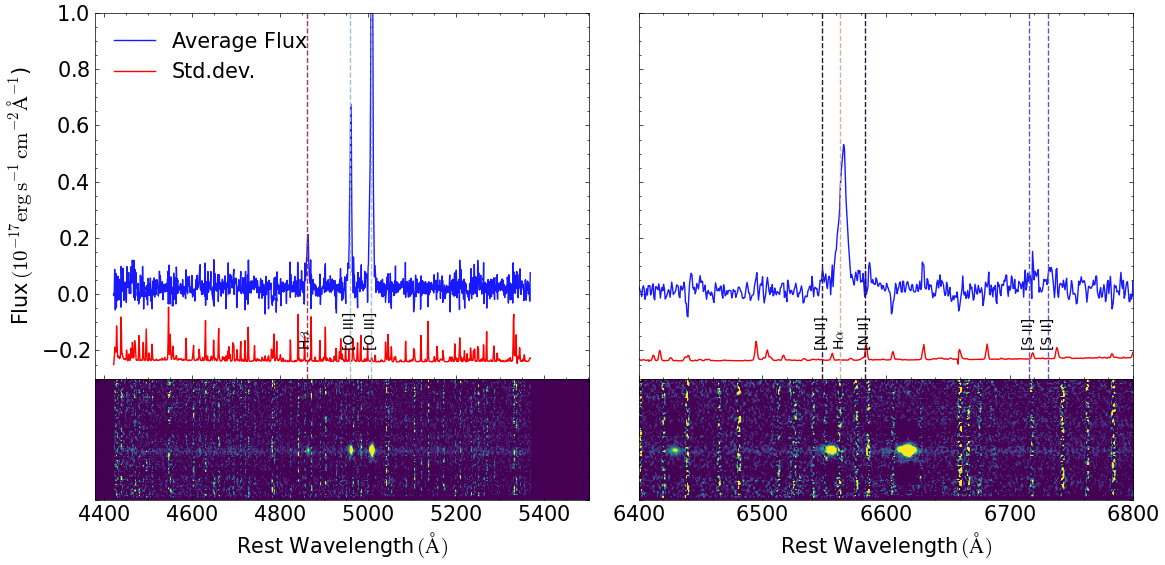

In [5]:
from matplotlib import gridspec
import matplotlib
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
fluxu=r"Flux$\,(10^{-17}\rm erg\,s^{-1}\,cm^{-2}\AA^{-1}$)"
rng1 = np.random.default_rng(122807528840384100672342137672332424406)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[3, 1], hspace=0.0)

ax1 = fig.add_subplot(gs[0,0])
ax1_sub = fig.add_subplot(gs[1,0],sharex=ax1)

ax2 = fig.add_subplot(gs[0,1],sharey=ax1)
ax2_sub = fig.add_subplot(gs[1,1],sharex=ax2)

ax2.tick_params(labelleft=False, labelbottom=False) 
ax1.tick_params(labelbottom=False)

ax2_sub.tick_params(labelleft=False) 
ax1_sub.tick_params(labelleft=False) 

ax1.plot(spec_axisH[maskH]/(1+redshift), flux_1dH[maskH], "b", label = "Average Flux",alpha=0.9)
ax2.plot(spec_axisK[maskK]/(1+redshift), flux_1dK[maskK], "b", alpha=0.9)

#ax2.plot(spec_axisK[maskK]/(1+redshift), mos2dK[0].data[2][maskK]-0.5, "m", alpha=0.9)
#ax1.plot(spec_axisH[maskH]/(1+redshift), mos2dH[0].data[2][maskH]-0.5, "m", alpha=0.9)

#ax.fill_between(x.value/(1+redshift), spec.value - sigma, spec.value + sigma, color='cyan', alpha=0.2, label='1-sigma region')
ax1.plot(spec_axisH[maskH]/(1+redshift), mos1dH[0].data[1][maskH]-0.25, "r", label = "Std.dev.")
ax2.plot(spec_axisK[maskK]/(1+redshift), mos1dK[0].data[1][maskK]-0.25, "r")

_, med, std = sigma_clipped_stats(mos2dK[0].data)
norm = vis.ImageNormalize(vmin = med, vmax = med+6*std, stretch = vis.LinearStretch())
#_, med, std = sigma_clipped_stats(mos2dH[0].data)
#normH = vis.ImageNormalize(vmin = med, vmax = med+6*std, stretch = vis.LinearStretch())

#ax1_sub.imshow(mos2dH[0].data)
ax2_sub.imshow(mos2dK[0].data,aspect="auto",extent=[spec_axisK.min()/(1+redshift),spec_axisK.max()/(1+redshift),0,51],norm=norm)
ax1_sub.imshow(mos2dH[0].data,aspect="auto",extent=[spec_axisH.min()/(1+redshift),spec_axisH.max()/(1+redshift),0,51],norm=norm)

#ax.plot(spectrum.spectral_axis, 1e4*y_fit, "g", label="Fit result")

keys=lines.keys()
colors=matplotlib.cm.twilight_shifted(np.arange(len(keys))/len(keys))

for ind,key in enumerate(keys):
    for line in lines[key]:
        if line < spec_axisK.max()/(1+redshift) and line > spec_axisK.min()/(1+redshift):
            ax2.text(line,-0.2,key, rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=10)
            ax2.axvline(line,ls="--",c=colors[ind])
        else:
            ax1.text(line,-0.2,key, rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=10)
            ax1.axvline(line,ls="--",c=colors[ind])

xlow=np.min(spec_axisH/(1+redshift))
xhigh=np.max(spec_axisK/(1+redshift))
ax1.legend()
ax1_sub.set_xlabel(r"Rest Wavelength$\,(\rm \AA)$")
ax2_sub.set_xlabel(r"Rest Wavelength$\,(\rm \AA)$")
ax1.set_ylabel(fluxu)
ax1.set_ylim(-0.3, 1)
ax2.set_xlim([6400,6800])
#ax1.set_xlim([5020,5350])
#ax.set_xlim([xlow,xhigh])
#ax.set_yscale("log")
#fig.savefig("./Q1549-BX101/fig/fitted_fig.png")
plt.tight_layout()

In [25]:
np.savetxt(datapath+"/mosfire/"+sourcename+"_H.txt",np.array([spec_axisH[maskH],flux_1dH[maskH],mos1dH[0].data[1][maskH]]).T)
np.savetxt(datapath+"/mosfire/"+sourcename+"_K.txt",np.array([spec_axisK[maskK],flux_1dK[maskK],mos1dK[0].data[1][maskK]]).T)

In [11]:
def write_boxcar_filter(file_name, filter_name, low, up, phot_ct=False, desc='no description'):
    '''
    Input:
        file_name, the file name to output
        filter_name, the name of the filter
                     should be different from any existing name
        low, up: wavelength range of the filter, units: Angstrom
    Keywords:
        phot_ct, True=photon counter
                 Falsse=energy counter
        desc, some descriptions in string
    Output:
        lams, wavelength in Angstrom
        trans, fractional transmission
    '''
    # Get the corresponding wavelength
    lam_lo, lam_up = low, up
    # Generate the grids
    lams = np.logspace(np.log10(lam_lo), np.log10(lam_up), 100)
    # Set the transmission profile
    trans = np.zeros(len(lams))+1.
    trans[0], trans[-1] = 0, 0

    with open(file_name, mode='w') as file:
        # Write the filter name
        file.write('# ' + filter_name + '\n')
        # Write filter type
        if phot_ct: file.write('# photon\n')
        else: file.write('# energy\n')
        # Write the description
        file.write('# ' + desc + '\n')
        # Wrtie the transmission curve
        # Note that cigale filter is in format of A
        # so need to multiply lam by a factor of 10
        # to convert nm to A
        for lam, tran in zip(lams, trans):
            file.write("%.2f %.3f \n" %(lam, tran))

    return None


In [67]:
rebinned={}
rebinned["Hband1"]=np.array([spec_axisH[maskH].min()/(1+redshift),4850])
rebinned["Hband2"]=np.array([5020,spec_axisH[maskH].max()/(1+redshift)])
rebinned["Kband1"]=np.array([spec_axisK[maskK].min()/(1+redshift),6500])
rebinned["Kband2"]=np.array([6750,spec_axisK[maskK].max()/(1+redshift)])

myfilter="/disk/bifrost/yuanze/cigale-v2022.1"
# extraction of pseudo broad band photometric data and corresponding boxcar filters
for band in rebinned.keys():
    write_boxcar_filter(myfilter+"/my_filters/"+sourcename+"_mosfire_"+band, sourcename+"_mosfire_"+band, rebinned[band][0]*(1+redshift), rebinned[band][1]*(1+redshift), desc='mosfire longslit pseudo broad band photometry')
    


## In this subsection, we will generate narrow band photometric images, avoding strong NLR lines which can be much greater than galaxy continuum 

In [35]:
#for band in rebinned.keys():
from scipy import stats as st
import pandas as pd
import re
for ind,band in enumerate(rebinned.keys()):
    if re.findall(r"Hband.+",band):
        wl = spec_axisH[maskH]
        mask = (wl < rebinned[band][1]*(1+redshift)) &  (wl > rebinned[band][0]*(1+redshift))
        pflam = flux_1dH[maskH][mask]*1e-17
        psigma = mos1dH[0].data[1][maskH][mask]*1e-17
    elif re.findall(r"Kband.+",band):
        wl = spec_axisK[maskK]
        mask = (wl < rebinned[band][1]*(1+redshift)) &  (wl > rebinned[band][0]*(1+redshift))
        pflam = flux_1dK[maskK][mask]*1e-17
        psigma = mos1dK[0].data[1][maskK][mask]*1e-17
    pwl= wl[mask]
    pnu= constants.c.to(u.AA/u.s).value/pwl
    pfnu= pflam*pwl**2/constants.c.to(u.AA/u.s).value
    pflux= np.trapz(pflam,x=pwl)/(pnu.max()-pnu.min())*1e26 #to mJy
    
    Dlam=pwl-np.roll(pwl,1)
    Dlam[0]=st.mode(Dlam,keepdims=False)[0]
    pflux_err=np.sqrt(np.sum((Dlam*psigma)**2))/(pnu.max()-pnu.min())*1e26 #to mJy
    if ind==0:
        psepho=pd.DataFrame([np.array([pflux,pflux_err])],columns=[sourcename+"_mosfire_"+band,sourcename+"_mosfire_"+band+"_err"])
    else:
        psepho=pd.concat([psepho,pd.DataFrame([np.array([pflux,pflux_err])],columns=[sourcename+"_mosfire_"+band,sourcename+"_mosfire_"+band+"_err"])],axis=1)

In [36]:
psepho

BX172_mosfire_Hband1  BX172_mosfire_Hband1_err  BX172_mosfire_Hband2  \
0               0.00201                  0.000125              0.002353   

   BX172_mosfire_Hband2_err  BX172_mosfire_Kband1  BX172_mosfire_Kband1_err  \
0                  0.000142              0.002175                  0.000179   

   BX172_mosfire_Kband2  BX172_mosfire_Kband2_err  
0              0.002689                  0.000238

# Spitzer-IRAC data inspection

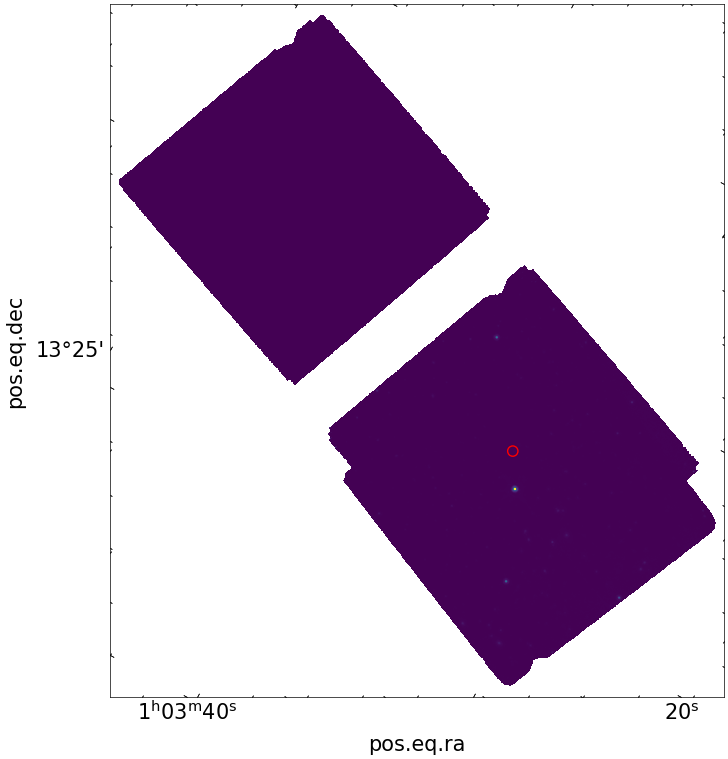

In [135]:
sc = SkyCoord(ra=15.78524, dec=13.27826, unit='deg',frame=FK5, equinox='J2000')
cube="Q0100"
sourcename="BX172"
datapath="/Users/yuanze/KBSS"+"/"+cube
hdu_irac=fits.open(datapath+"/irac/q0100_irac_ch4_mosaic.fits")
wcs=WCS(hdu_irac[0].header)
_, med, std = sigma_clipped_stats(hdu_irac[0].data)


norm = vis.ImageNormalize(vmin = med, vmax = med+6*std)

fig = plt.figure(figsize=(16,9))
ax = plt.subplot(projection = wcs)
ax.imshow(hdu_irac[0].data,norm=norm)
pixsc=wcs.world_to_pixel(sc)
#ax.plot(pixsc[0],pixsc[1],"ro",markeredgewidth=.1,lw=0.01)
plt.scatter(pixsc[0],pixsc[1], s=55, facecolors='none', edgecolors='r')

# Herschel inspection

INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


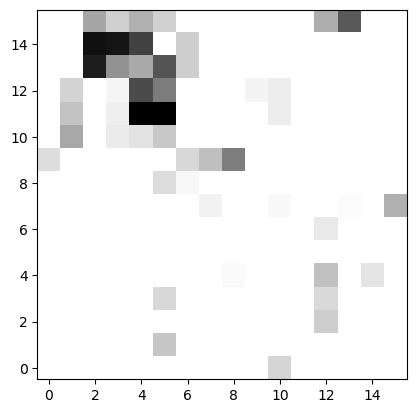

In [35]:
import sys
sys.path.append('/disk/bifrost/yuanze/software/GalfitS/src')
import os
from astropy.visualization.mpl_normalize import simple_norm
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import images as IM
cutr = float (50) #50 arcsec size

ra=32.47523
dec=-0.07491
sc = SkyCoord(ra=ra, dec=dec, unit='deg',frame=ICRS, equinox='J2000')
cube="Q0207"
sourcename="BX298"
datapath="/disk/bifrost/yuanze/KBSS"+"/"+cube+"/"+sourcename
fname=datapath+"/herschel/irsa.ipac.caltech.edu/data/Herschel/HHLI/images/01p\
/SpirePhoto/0140p0005_1342247220_SpirePhoto_L25_PMP350_SPG14.0.fits"
#hdu_herschel=fits.open()
#wcs=WCS(hdu_herschel[1].header)
#_, med, std = sigma_clipped_stats(hdu_herschel[1].data)


img = IM.image(fname)
hdu = fits.open(fname)
imcut, cp = img.img_cut(ra,dec,cutr)
sky_mean, sky_median, sky_std = sigma_clipped_stats(imcut, sigma=3, maxiters=5)
header = img.data.header

sigimg = img.cal_sigma_image(1e5, gain = 1.)
img.cut_sigma_image = sigimg[cp[2]:cp[3],cp[0]:cp[1]]
#img.cut_mask_image = np.zeros_like(img.cut_sigma_image)
#img.cut_mask_image = img.generate_cutmask(1.,nsigma=3,sky_level=sky_mean,deblend=False,addgrow=3)

norm = simple_norm([sky_std, 3*sky_std], 'linear', percent=100)
plt.imshow(imcut-sky_median,origin='lower',cmap='gray_r',norm=norm)
#plt.imshow(img.cut_mask_image,origin='lower',cmap='Blues',alpha=img.cut_mask_image.astype(float)*0.5)
plt.show()

In [36]:
print(img.coordinates_transfer_para)

{'x0': 8.091192906431388, 'x0shift': 0.0, 'y0': 8.602488703545987, 'y0shift': 0.0, 'dxra': -0.17941122450674812, 'dxdec': -0.00036310178108275675, 'dyra': -6.251184534373048e-05, 'dydec': 0.17292013114602015, 'pixsc': 6.0000000000012, 'delta_ang': 89.87966823168088}


# HST inspection

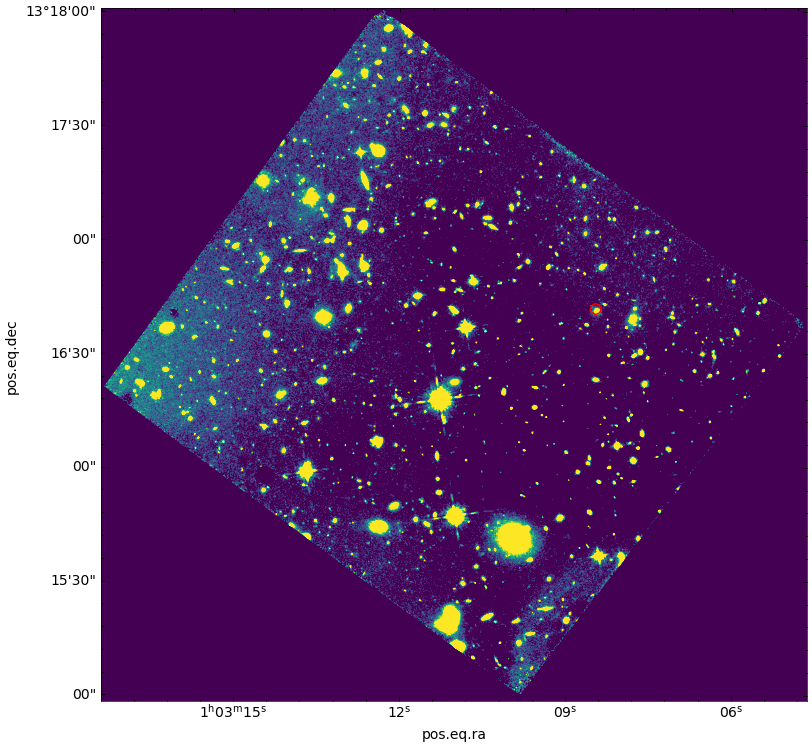

In [180]:
sc = SkyCoord(ra=15.78524, dec=13.27826, unit='deg',frame=FK5, equinox='J2000')
RA=15.78524
DEC=13.27826
#ava=["q0100_wfc3.fits","m0307b.wf3.fits"]
hdu=fits.open(KBSSpath+"/"+cubename+"/HST/q0100_wfc3.fits")
#hdu=fits.open(datapath+"/hst/u54k0103b.wf3.fits")
wcsall=WCS(hdu[0].header)
#groupn=2
#wcs=wcsall.slice((groupn,), numpy_order=True)
wcs=wcsall
_, med, std = sigma_clipped_stats(hdu[0].data)


norm = vis.ImageNormalize(vmin = med, vmax = med+6*std)

#f#ig = plt.figure(figsize=(16,9))
fig, ax = plt.subplots(subplot_kw={'projection': wcs},figsize=(16,9))
#ax.imshow(hdu[0].data[groupn,:,:],norm=norm)
ax.imshow(hdu[0].data,norm=norm)
#pixsc=wcs.world_to_pixel(sc)
#ax.plot(pixsc[0],pixsc[1],"ro",markeredgewidth=.1,lw=0.01)
#plt.scatter(pixsc[0],pixsc[1], s=55, facecolors='none', edgecolors='r')
ax.scatter(RA, DEC, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')

In [184]:
1/hdu[0].header['PHOTFLAM']

5.233945591565392e+19

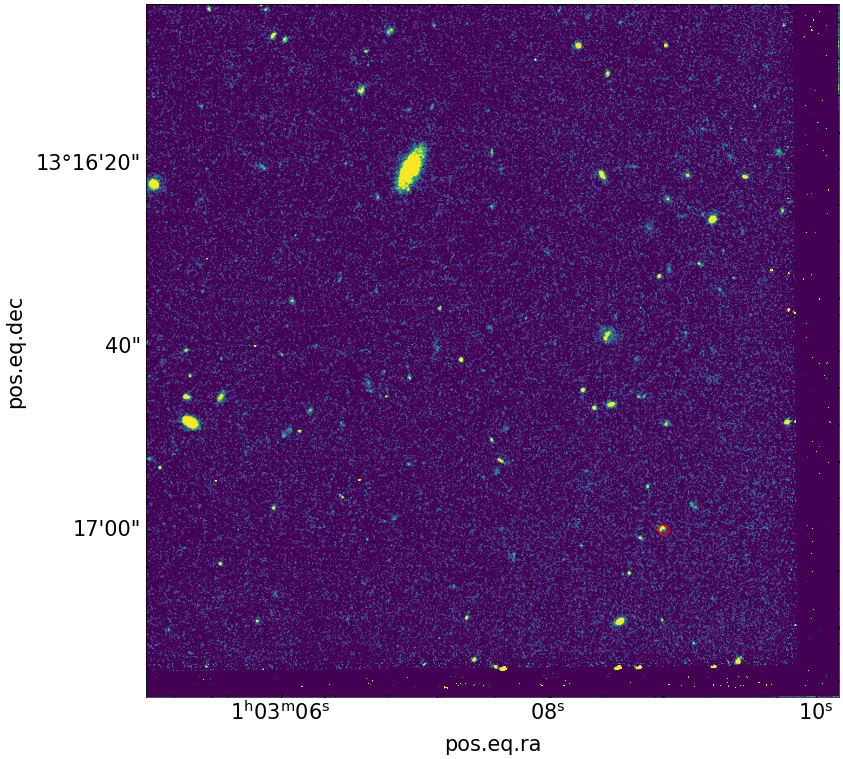

In [128]:
sc = SkyCoord(ra=15.78524, dec=13.27826, unit='deg',frame=FK5, equinox='J2000')
RA=15.78524
DEC=13.27826
#ava=["q0100_wfc3.fits","m0307b.wf3.fits"]
#hdu=fits.open(datapath+"/hst/q0100_f410m.fits")
hdu=fits.open(datapath+"/hst/m0307b.wf3.fits")
wcsall=WCS(hdu[0].header)
groupn=1
#wcs=wcsall.slice((groupn,), numpy_order=True)
wcs=wcsall
_, med, std = sigma_clipped_stats(hdu[0].data)


norm = vis.ImageNormalize(vmin = med, vmax = med+6*std)

fig = plt.figure(figsize=(16,9))
ax = plt.subplot(projection = wcs)
#ax.imshow(hdu[0].data[groupn,:,:],norm=norm)
ax.imshow(hdu[0].data,norm=norm)
#pixsc=wcs.world_to_pixel(sc)
#ax.plot(pixsc[0],pixsc[1],"ro",markeredgewidth=.1,lw=0.01)
#plt.scatter(pixsc[0],pixsc[1], s=55, facecolors='none', edgecolors='r')
ax.scatter(RA, DEC, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')

# Reading photometric data
### Treating broad-line objects and narrow-line objects separately. 

Let's deal with narrow-line object first, making a general template from Q0100-BX172


In [15]:
from astropy.io import ascii
KBSSpath="/disk/bifrost/yuanze/KBSS"
cubename="Q0100"
sourcename="BX172"
#redshift=2.3806
datapath=KBSSpath+"/"+cubename+"/"+sourcename

def MAB2Flam(MAB,Lambda):
    """
    Convert AB magnitude to flux density in cgs units of erg/s/cm^3.
    M_{AB}=-2.5\log_{10}f_{\nu}-48.60
    
    Parameters:
    MAB (float): AB magnitude
    Lambda (float): Wavelength in cm

    Returns:
    float: Flux density in cgs units of erg/s/cm^3
    """
    ccgs=constants.c.to(u.cm/u.s).value
    fnu=10**((MAB+48.6)/(-2.5))
    return fnu*ccgs/Lambda**2

def MAB2mJy(MAB):
    "{\displaystyle m_{\text{AB}}=-2.5\log _{10}f_{\nu }+8.90.}"
    return 10**(-0.4*(MAB-8.9))*1e3
    
effective_wave ={
    # Subaru FOCAS
    'focas_U' : 3600.,
    'B_subaru' : 4400.,
    'focas_V' : 5500.,
    'focas_R' : 6600.,
    'focas_I' : 8050.,
    # Spitzer-IRAC
    'irac1':36000.,
    'irac2':45000.,
    'irac3':58000.,
    'irac4':80000.,
    # Keck-LRIS
    'Un_lris':3450.,
    'B_lris':4370.,
    'G_lris':4731.,
    'V_lris':5437.,
    'B_lris_B':4377.,
    'V_lris_B':5473.,
    'R_lris':6417.,
    'I_lris':7599.,
    'Rs_lris':6809.,
    # Keck-MOSFIRE
    'mosfire_Y':10480.,
    'mosfire_J':12530.,
    'mosfire_H':16370.,
    'mosfire_Ks':21470.,
    'f140w':14000,
    'f125w':12500,
    'f160w':16000
}

photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"
filterpath=photpath+"/filters_standard."+cubename.lower()+".v2"
all_filters = ascii.read(filterpath)['col1']
inphot = ascii.read(photpath+"/inphot/"+cubename.lower()+"_inphot_refit.dat")
photentry=inphot[inphot['col1']==cubename+"-"+sourcename]

print(photentry)
print(all_filters)

    col1     col2 col3  col4 col5  col6 ... col21 col22 col23 col24 col25 col26
----------- ----- ---- ----- ---- ----- ... ----- ----- ----- ----- ----- -----
Q0100-BX172 24.53 0.12 23.67  0.1 23.74 ...  0.22 22.62   0.1 21.97   0.1 2.312
   col1   
----------
   Un_lris
  B_subaru
    G_lris
   Rs_lris
 mosfire_J
 mosfire_H
mosfire_Ks
     irac1
     irac2
     irac3
     f140w
     f160w


In [118]:
import pandas as pd
from dust_extinction.parameter_averages import G23
import astropy.units as u
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord

inphot_pd=photentry.to_pandas()
cigale_filters=[]
filterlist=[]
rawdata=[]
wavelength=[]
for ind,ff in enumerate(all_filters):
    if photentry.columns[1+ind*2].data[0] < 999.:
        rawdata.append(MAB2mJy(inphot_pd["col{}".format(2+2*ind)]))
        wavelength.append(effective_wave[ff])
        match ff:
            case 'f160w':
                filterlist.append("hst.wfc3.F160W")
                cigale_filters.append("hst.wfc3.F160W")
                cigale_filters.append("hst.wfc3.F160W_err")
            case 'f140w':
                filterlist.append("hst.wfc3.F140W")
                cigale_filters.append("hst.wfc3.F140W")
                cigale_filters.append("hst.wfc3.F140W_err")
            case 'f125w':
                filterlist.append("hst.wfc3.F125W")
                cigale_filters.append("hst.wfc3.F125W")
                cigale_filters.append("hst.wfc3.F125W_err")
            case 'irac1':
                filterlist.append("spitzer.irac.ch1")
                cigale_filters.append("spitzer.irac.ch1")
                cigale_filters.append("spitzer.irac.ch1_err")
            case 'irac2':
                filterlist.append("spitzer.irac.ch2")
                cigale_filters.append("spitzer.irac.ch2")
                cigale_filters.append("spitzer.irac.ch2_err")
            case 'irac3':
                filterlist.append("spitzer.irac.ch3")
                cigale_filters.append("spitzer.irac.ch3")
                cigale_filters.append("spitzer.irac.ch3_err")
            case 'irac4':
                filterlist.append("spitzer.irac.ch4")
                cigale_filters.append("spitzer.irac.ch4")
                cigale_filters.append("spitzer.irac.ch4_err")
            case 'B_subaru':
                filterlist.append("subaru.suprime.B")
                cigale_filters.append("subaru.suprime.B")
                cigale_filters.append("subaru.suprime.B_err")
            case _:
                filterlist.append(ff)
                cigale_filters.append(ff)
                cigale_filters.append(ff+"_err")
        inphot_pd["col{}".format(2+2*ind)]=MAB2mJy(inphot_pd["col{}".format(2+2*ind)])
        inphot_pd["col{}".format(3+2*ind)]=inphot_pd["col{}".format(3+2*ind)]*inphot_pd["col{}".format(2+2*ind)]/1.086
    else:
        inphot_pd=inphot_pd.drop(["col{}".format(2+2*ind),"col{}".format(3+2*ind)],axis=1)

cols = inphot_pd.columns.tolist()  # Get a list of all columns
cols.insert(1, cols.pop(-1)) 
inphot_pd = inphot_pd[cols]
inphot_pd.columns=["#id","redshift"]+cigale_filters

#There's no IRAC-ch4 detection for BX172, but may be available for other sources
loc = inphot_pd.columns.get_loc('spitzer.irac.ch3_err') + 1
inphot_pd.insert(loc,'spitzer.irac.ch4','nan')
inphot_pd.insert(loc+1,'spitzer.irac.ch4_err','nan')
loc = inphot_pd.columns.get_loc('spitzer.irac.ch4_err') + 1
inphot_pd.insert(loc,'hst.wfc3.F125W','nan')
inphot_pd.insert(loc+1,'hst.wfc3.F125W_err','nan')

#inphot_pd=pd.concat([inphot_pd,psepho],axis=1)
#for ind in range(int(len(psepho.columns)/2)):
#    filterlist.append(psepho.columns[2*ind])


After inspection of MOSFIRE spectrum, we decided to drop JHK photometry of MOSFIRE in order to avoid the complications of narrow line region

In [119]:
drop=["mosfire_H","mosfire_Ks","hst.wfc3.F160W"]
#droplist=np.ravel([[obj,obj+"_err"] for obj in drop])
#inphot_pd=inphot_pd.drop(droplist,axis=1)
for remv in drop:
    filterlist.remove(remv)
    inphot_pd[remv]='nan'
    inphot_pd[remv+"_err"]='nan'

In [120]:
inphot_pd

#id  redshift  Un_lris  Un_lris_err  subaru.suprime.B  \
0  Q0100-BX172     2.312  0.00056     0.000062          0.001236   

   subaru.suprime.B_err    G_lris  G_lris_err   Rs_lris  Rs_lris_err  ...  \
0              0.000114  0.001159    0.000107  0.001459     0.000134  ...   

   spitzer.irac.ch3  spitzer.irac.ch3_err spitzer.irac.ch4  \
0          0.014588              0.002955              nan   

  spitzer.irac.ch4_err hst.wfc3.F125W hst.wfc3.F125W_err  hst.wfc3.F140W  \
0                  nan            nan                nan        0.003251   

   hst.wfc3.F140W_err  hst.wfc3.F160W  hst.wfc3.F160W_err  
0            0.000299             nan                 nan  

[1 rows x 30 columns]

# In this section, we are going to do final corrections of the photometric data, 

## We will generate filter transmission curve so as to understand the photometric coverage at the same time

## except for that, we are going to do MW extinction correction for photometric data (though it has only a small effect on most of the data).

In [121]:
from astropy.io import fits
cfilter="/disk/bifrost/yuanze/cigale-v2022.1/database_builder/filters/gazpar"
myfilter="/disk/bifrost/yuanze/cigale-v2022.1"

In [122]:

#=============================== Caution! Don't execute this block more than once! ===========================================#

import re
#lam=np.logspace(np.log10(np.min(filters_wl)), np.log10(30), num=1000) * u.micron
#plt.loglog(lam,ext_model(lam))
ext_model = G23(Rv=3.1)
RA=15.78524
DEC=13.27826
sc = SkyCoord(ra=RA, dec=DEC, unit='deg',frame='icrs', equinox='J2000')
sfd = SFDQuery()
Av=sfd(sc)*2.742


curve={}
filters_wl={}
for filter in filterlist:
    ftype="photon"
    if re.findall(r"^mosfire.+",filter):
        match=re.findall(r"^mosfire.+",filter)[0]
        curve[match]=np.genfromtxt(myfilter+"/mosfire_filters/"+match+".dat")
    elif re.findall(r".+mosfire.+",filter):
        match=re.findall(r".+mosfire.+",filter)[0]
        curve[match]=np.genfromtxt(myfilter+"/my_filters/"+match)
        ftype="energy"
    if re.findall(r"hst.wfc3.+",filter):
        match=re.findall(r"hst.wfc3.+",filter)[0]
        curve[match]=np.genfromtxt(cfilter+"/hst/wfc3/"+re.findall(r"F.+",match)[0]+".pb")
    if re.findall(r"spitzer.+",filter):
        match=re.findall(r"spitzer.+",filter)[0]
        curve[match]=np.genfromtxt(cfilter+"/spitzer/"+re.findall(r"irac|mips",match)[0]+"/"+re.findall(r"ch.",match)[0]+".pb")
    if re.findall(r"subaru.+",filter):
        match=re.findall(r"subaru.+",filter)[0]
        curve[match]=np.genfromtxt(cfilter+"/subaru/suprime/"+re.findall(r"\w+$",match)[0]+".pb")
    if re.findall(r".+lris$",filter):
        match=re.findall(r".+lris",filter)[0]
        curve[match]=np.genfromtxt(myfilter+"/lris_filters/"+match+".dat")

    #Assuming all filters have been taken care of
    wl=curve[match][:,0]
    if ftype == "photon":
        tr=curve[match][:,1]*wl
    else:
        tr=curve[match][:,1]
    # pivot wavelength of filters
    
    filters_wl[match]=np.sqrt(np.trapz(tr, wl) / np.trapz(tr / wl**2, wl))
    # After getting the pivot wavelength, we correct the photometric points from Milky Way extinction, according to Gordon+23 extinction curve and SFD dust map, assuming Rv=Av/E_B-V=3.1
    # For SFD map, Av= 2.742 EBV

    Alam=ext_model(filters_wl[match]*u.AA)*Av
    inphot_pd[match]=inphot_pd[match]*10**(0.4*Alam)
    inphot_pd[match+"_err"]=inphot_pd[match+"_err"]*10**(0.4*Alam)

#filters_wl=np.array(filters_wl)*1e-4




In [123]:
filters_wl

{'Un_lris': 3503.5458607055502,
 'subaru.suprime.B': 4448.023438983498,
 'G_lris': 4742.1637744443915,
 'Rs_lris': 6821.364126897691,
 'mosfire_J': 12516.630532525664,
 'spitzer.irac.ch1': 35569.17878413092,
 'spitzer.irac.ch2': 45020.33663622542,
 'spitzer.irac.ch3': 57450.525321313646,
 'hst.wfc3.F140W': 13924.392725390951}

Finished! All filters' transmission curves have been loaded into a dictionary "curve"

Next step is to read the result from CIGALE and do the ploting by ourself

We (finally) write the photometric data to a ASCII file, in CIGALE readable format

In [124]:
with open("/disk/bifrost/yuanze/my_work/cigale/data_{}".format(cubename+"_"+sourcename), 'w') as f:
    f.write(inphot_pd.to_string(index=False))

attenuation.E_BVs.stellar.young, sfh.burst_age, attenuation.E_BVs.stellar.old unknown

Available variables are: 

sfh.sfr, sfh.sfr10Myrs, sfh.sfr100Myrs, sfh.age, sfh.integrated, sfh.age_main, sfh.tau_main, sfh.age_burst, sfh.tau_burst, 
sfh.f_burst, stellar.imf, stellar.metallicity, stellar.old_young_separation_age, stellar.m_star_young, stellar.m_gas_young, 
stellar.n_ly_young, stellar.lum_ly_young, stellar.lum_young, stellar.m_star_old, stellar.m_gas_old, stellar.n_ly_old, 
stellar.lum_ly_old, stellar.lum_old, stellar.m_star, stellar.m_gas, stellar.n_ly, stellar.lum_ly, stellar.lum, 
stellar.age_m_star, nebular.f_esc, nebular.f_dust, dust.luminosity, nebular.lines_width, nebular.logU, nebular.zgas, 
nebular.ne, attenuation.B_B90, attenuation.V_B90, attenuation.FUV, attenuation.E_BV_lines, attenuation.E_BVs, 
attenuation.E_BV_factor, attenuation.uv_bump_wavelength, attenuation.uv_bump_width, attenuation.uv_bump_amplitude, 
attenuation.powerlaw_slope, agn.fracAGN_dale2014, dust.alpha, agn.t, agn.pl, agn.q, agn.oa, agn.R, agn.Mcl, agn.i, 
agn.fracAGN, agn.law, agn.EBV, agn.temperature, agn.emissivity, agn.disk_type, agn.delta, agn.total_dust_luminosity, 
agn.polar_dust_luminosity, agn.torus_dust_luminosity, agn.disk_luminosity, agn.luminosity, agn.accretion_power, 
agn.intrin_Lnu_2500A_30deg, agn.L_6um, universe.redshift, universe.luminosity_distance, universe.age.

# Visualization of CIGALE's fitting result 

In [132]:
from astropy.cosmology import Planck18
from scipy.constants import c
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table
from pcigale.utils.io import read_table
path_to_result="/disk/bifrost/yuanze/my_work/cigale/out"

mod=Table.read(path_to_result+"/results.fits")
sed=Table.read(path_to_result+"/Q0100-BX172_best_model.fits")
obs=Table.read(path_to_result+"/observations.fits")
fitlist=obs.columns[2::2]
#obs_fluxes = np.array([obs[filt].value for filt in filterlist]).ravel()
#obs_fluxes_err = np.array([obs[filt+"_err"].value for filt in filterlist]).ravel()
fit_filter_wl= np.array([filters_wl[filt] for filt in fitlist])*1e-4
obs_fluxes = np.array([inphot_pd[filt] for filt in fitlist]).ravel()
obs_fluxes_err = np.array([inphot_pd[filt+"_err"] for filt in fitlist]).ravel()

#observed fluxes in mJy
mod_fluxes = np.array([mod["best."+filt].value for filt in fitlist]).ravel()
#model fluxes in mJy

wavelength_spec = sed["wavelength"].value*1e-3
# wavelength in micron

z=obs["redshift"].value[0]
zp1 = 1.0 + z
surf = 4.0 * np.pi * mod["best.universe.luminosity_distance"] ** 2
fact = 1e29 * 1e-3 * wavelength_spec ** 2 / c / surf

for cname in sed.colnames[1:]:
    sed[cname] *= fact


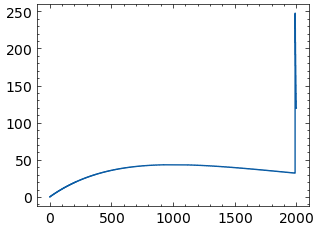

In [145]:
SFH=Table.read(path_to_result+"/Q0100-BX172_SFH.fits")
plt.step(SFH['time'],SFH["SFR"])


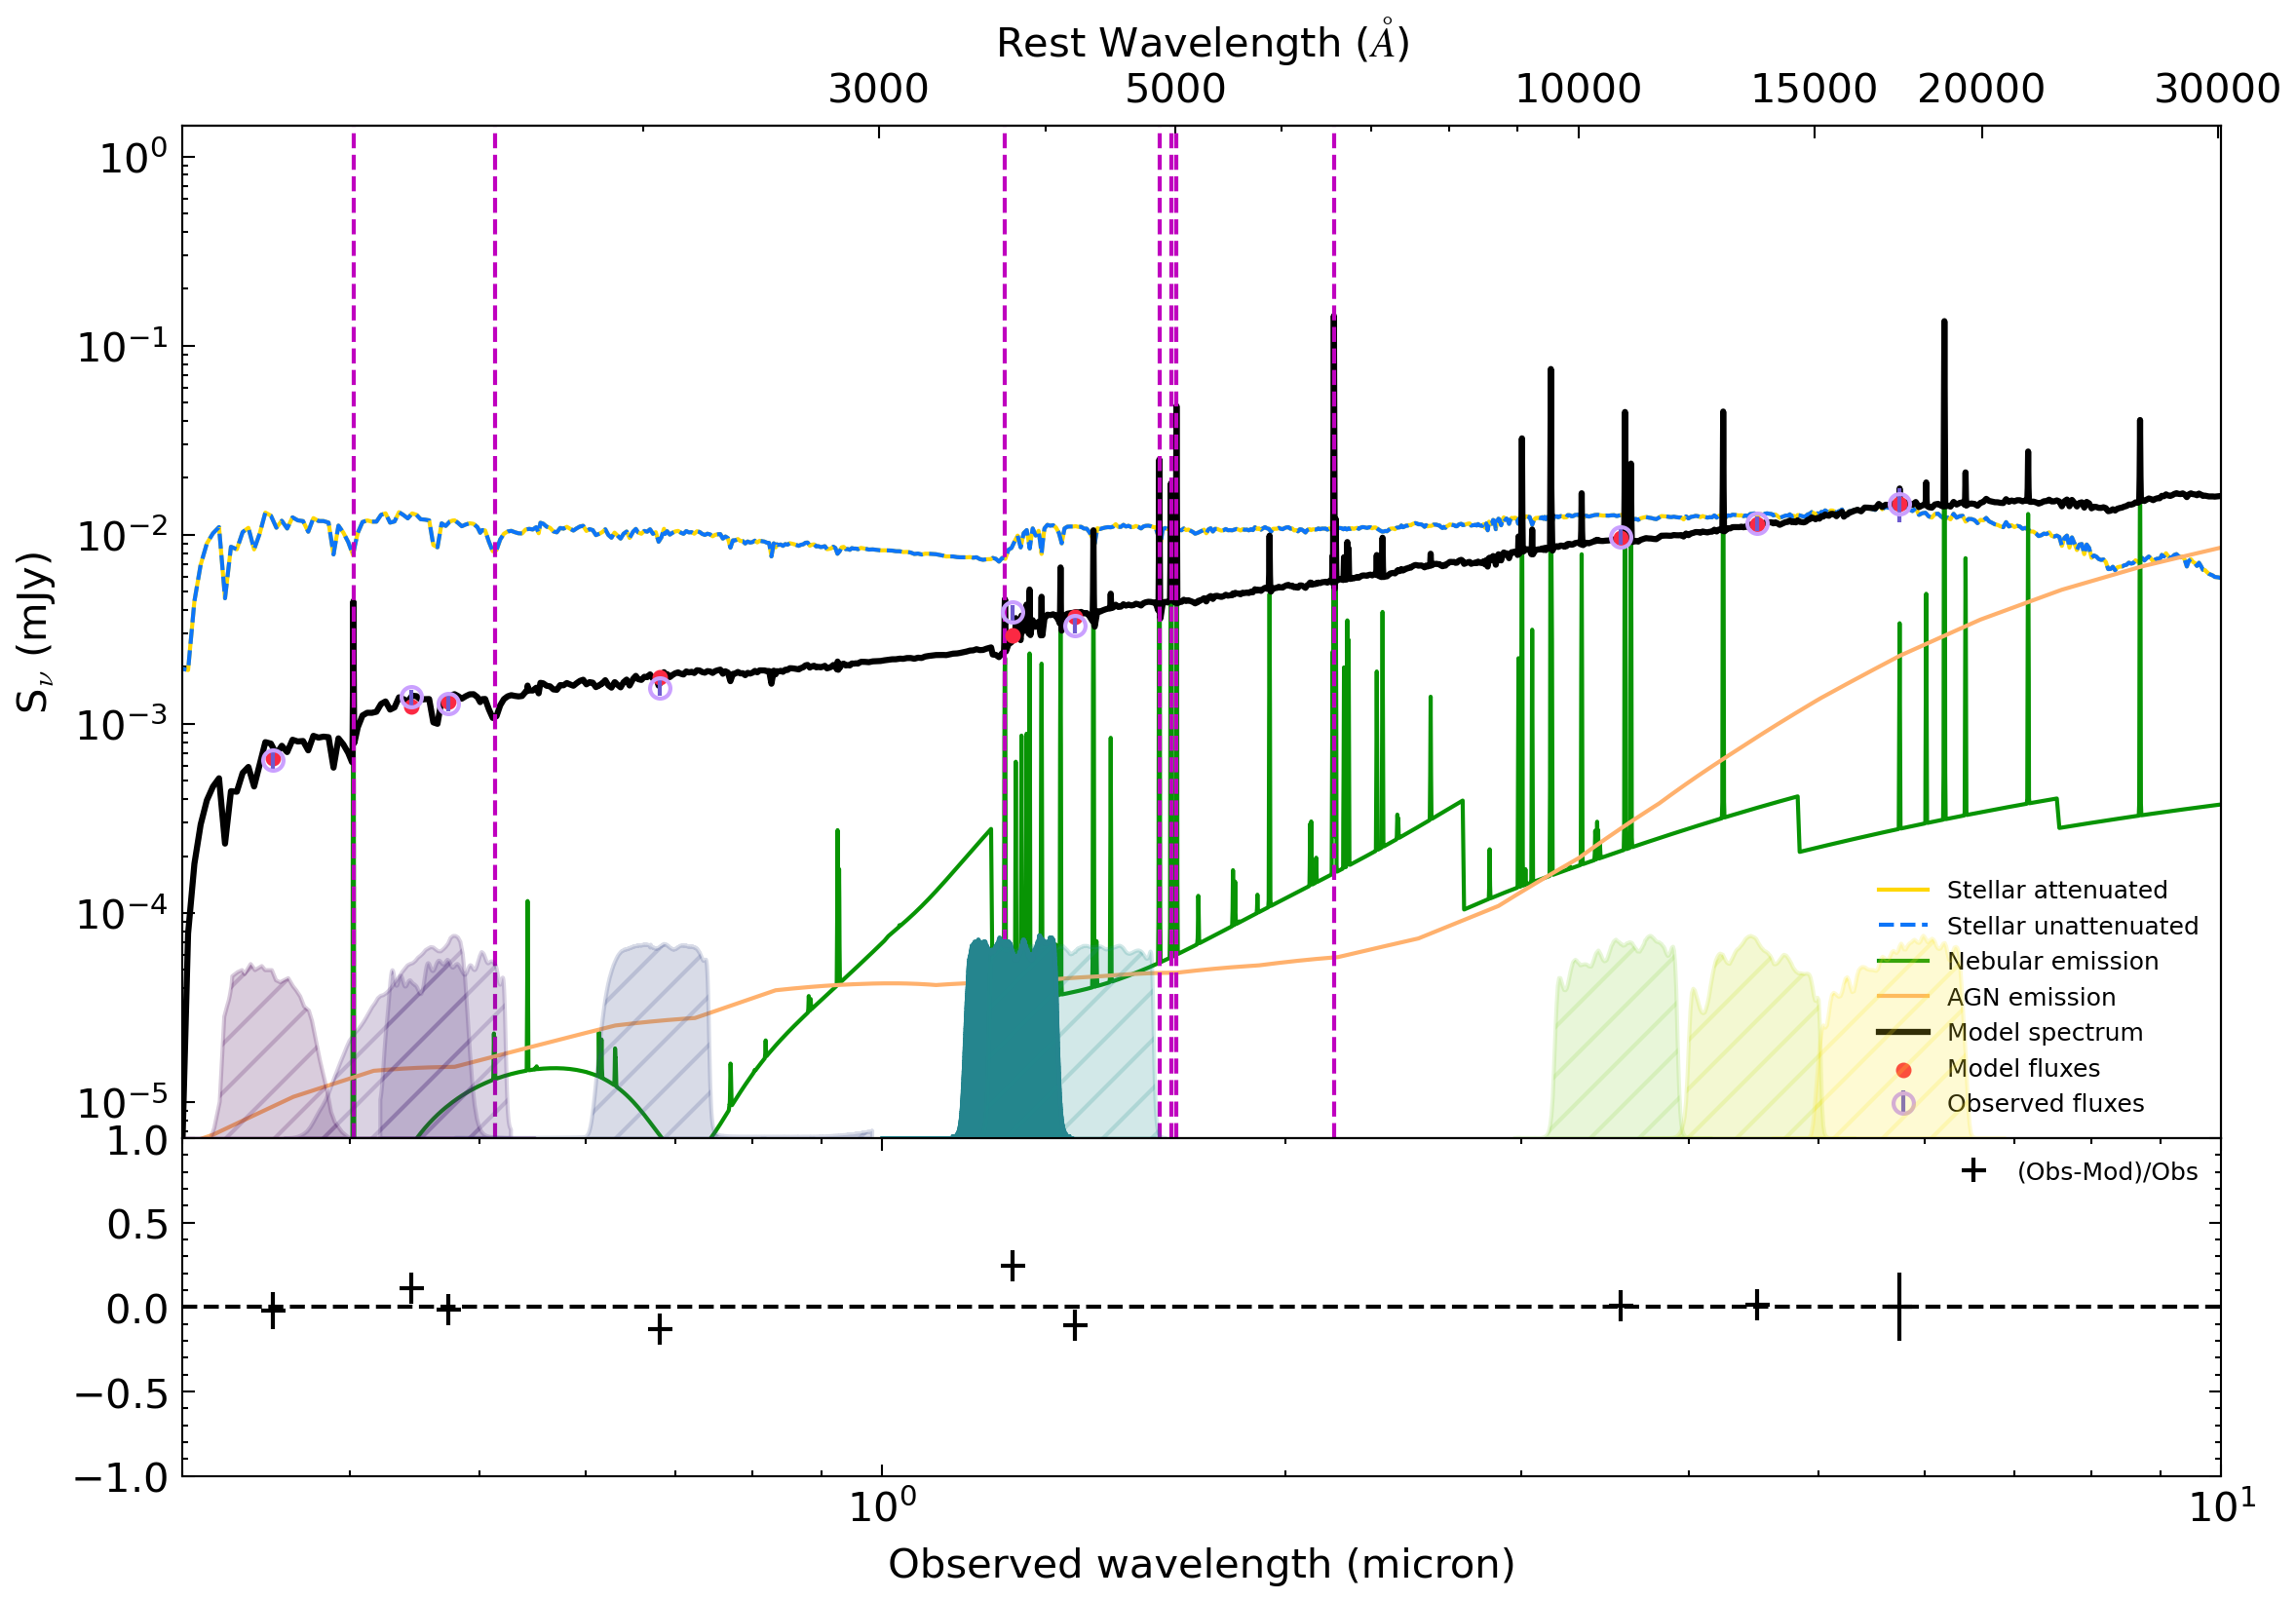

In [133]:
import scienceplots
import matplotlib.colors as mcolors
plt.style.use(['science','no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})

def obs2rest(x):
    return x/zp1*1e4
def rest2obs(x):
    return x*zp1/1e4

figure = plt.figure(figsize=(9,6),dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0)

plotseries=["stellar_attenuated","stellar_unattenuated","nebular","agn","FullModel"]
fplotlist=['mosfire_J']

if (sed.columns[1]> 0.0).any():
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1],sharex=ax1)

#attenuated Stellar emission
    if "stellar_attenuated" in plotseries and "stellar.young" in sed.columns:
        spectrum = sed["stellar.young"] + sed["stellar.old"]
        if "nebular.absoroption_young" in sed.columns:
            spectrum += sed["nebular.absortion_young"]
            spectrum += sed["nebular.absorption_old"]
        ax1.loglog(
                        wavelength_spec,
                        spectrum,
                        label="Stellar attenuated",
                        color="gold",
                        marker=None,
                        nonpositive="clip",
                        linestyle="-",
                        linewidth=1.0,
                    )

# Unattenuated Stellar emission
    if "stellar_unattenuated" in plotseries and "attenuation.stellar.young" in sed.columns:
        ax1.loglog(
                        wavelength_spec,
                        (sed["stellar.old"] + sed["stellar.young"]),
                        label="Stellar unattenuated",
                        color="xkcd:deep sky blue",
                        marker=None,
                        nonpositive="clip",
                        linestyle="--",
                        linewidth=1.0,
                    )

# Nebular emission
    if "nebular" in plotseries and "nebular.lines_young" in sed.columns:
        spectrum = (
            sed["nebular.lines_young"]
            + sed["nebular.lines_old"]
            + sed["nebular.continuum_young"]
            + sed["nebular.continuum_old"]
        )

        if "attenuation.nebular.lines_young" in sed.columns:
            spectrum += sed["attenuation.nebular.lines_young"]
            spectrum += sed["attenuation.nebular.lines_old"]
            spectrum += sed["attenuation.nebular.continuum_young"]
            spectrum += sed["attenuation.nebular.continuum_old"]

        ax1.loglog(
            wavelength_spec,
            spectrum,
            label="Nebular emission",
            color="xkcd:true green",
            marker=None,
            nonpositive="clip",
            linewidth=1.0,
        )
# Dust emission Dale
    if "dust" in plotseries and "dust" in sed.columns:
        ax1.loglog(
            wavelength_spec,
            sed["dust"],
            label="Dust emission",
            color="xkcd:bright red",
            marker=None,
            nonpositive="clip",
            linestyle="-",
            linewidth=1.0,
        )

# AGN emission
    if "agn" in plotseries and (
                    "agn.fritz2006_torus" in sed.columns
                    or "agn.SKIRTOR2016_torus" in sed.columns
                ):
        if "agn.fritz2006_torus" in sed.columns:
            agn_sed = (
                sed["agn.fritz2006_polar_dust"]
                + sed["agn.fritz2006_torus"]
                + sed["agn.fritz2006_disk"]
            )
        elif "agn.SKIRTOR2016_torus" in sed.columns:
            agn_sed = (
                sed["agn.SKIRTOR2016_polar_dust"]
                + sed["agn.SKIRTOR2016_torus"]
                + sed["agn.SKIRTOR2016_disk"]
            )
        if "xray.agn" in sed.columns:
            agn_sed += sed["xray.agn"]
        if "radio.agn" in sed.columns:
            agn_sed += sed["radio.agn"]
        ax1.loglog(
            wavelength_spec,
            agn_sed,
            label="AGN emission",
            color="xkcd:apricot",
            marker=None,
            nonpositive="clip",
            linestyle="-",
            linewidth=1.0,
                    )

    if "FullModel" in plotseries:
        ax1.loglog(
            wavelength_spec,
            sed["L_lambda_total"],
            label="Model spectrum",
            color="k",
            nonpositive="clip",
            linestyle="-",
            linewidth=1.5,
        )
 #   ax1.set_autoscale_on(False)
#    s = np.argsort(filters_wl)
#    filters_wl = filters_wl[s]
#    mod_fluxes = mod_fluxes[s]
#    obs_fluxes = obs_fluxes[s]
#    obs_fluxes_err = obs_fluxes_err[s]
    ax1.scatter(
        fit_filter_wl,
        mod_fluxes,
        marker="o",
        color="xkcd:strawberry",
        s=8,
        zorder=3,
        label="Model fluxes",
    )
    # observational data
    mask_ok = np.logical_and(obs_fluxes > 0.0, obs_fluxes_err > 0.0)
    ax1.errorbar(
        fit_filter_wl[mask_ok],
        obs_fluxes[mask_ok],
        yerr=obs_fluxes_err[mask_ok],
        ls="",
        marker="o",
        label="Observed fluxes",
        markerfacecolor="None",
        markersize=5,
        markeredgecolor="xkcd:pastel purple",
        color="xkcd:light indigo",
        capsize=0.0,
        zorder=3,
        lw=1,
    )

    mask = np.where(obs_fluxes > 0.0)
    ax2.errorbar(
        fit_filter_wl[mask],
        (obs_fluxes[mask] - mod_fluxes[mask]) / obs_fluxes[mask],
        yerr=obs_fluxes_err[mask] / obs_fluxes[mask],
        marker="_",
        label="(Obs-Mod)/Obs",
        color="k",
        capsize=0.0,
        ls="None",
        lw=1,
    )
    ax2.axhline(y=0, ls="--", color="k")
    ax2.set_xscale("log")
#    ax2.minorticks_on()
    ax1.tick_params(
        direction="in",
        axis="both",
        which="both",
        top=False,
        left=True,
        right=True,
        bottom=False,
    )
    ax2.tick_params(
        direction="in", axis="both", which="both", right=True
    )
    ymin=np.min(obs_fluxes[mask_ok])
    ymax=np.max(obs_fluxes[mask_ok])

    waverange=[0.3,1e1]
    xticks=np.array([3000,5000,10000,15000,20000,30000],dtype=int)
    lines=np.array([1216,1550,3727,4861,4959,5007,6563])
    for line in lines:
        ax1.axvline(line/1e4*zp1,ls="--",color="m")
    ax1.set_ylim([ymin*1e-2,ymax*1e2])
    ax1.set_xlim(waverange)
    ax2.set_ylim(-1.0, 1.0)
    ax1.legend(fontsize=6, loc="best", frameon=False)
    ax2.legend(fontsize=6, loc="best", frameon=False)
    ax2.set_xlabel("Observed wavelength (micron)")
    ax1.set_ylabel(r"S$_\nu$ (mJy)")
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels()[1], visible=False)

    secax=ax1.secondary_xaxis(1,functions=(obs2rest,rest2obs))
    secax.set_xlabel(r'Rest Wavelength ($\AA$)')
    secax.set_xticks(xticks)
    secax.set_xticklabels(xticks.astype(str))
    ax1_2 = ax1.twinx()
    ax1_2.set_xscale('log')
    ax1_2.set_xlim(ax1.get_xlim())
    ax1_2.set_ylim([0,5])
    ax1_2.tick_params(
                    direction="in",
                    axis="both",
                    which="both",
                    top=False,
                    left=False,
                    right=False,
                    bottom=False,
                )
    secax.tick_params(
                    direction="in",
                    axis="both",
                    which="both",
                    top=True,
                    left=False,
                    right=False,
                    bottom=False,
                )
    ax1_2.set_yticks([])
    cm = plt.cm.viridis
    norm = mcolors.LogNorm(vmin=min(fit_filter_wl), vmax=max(fit_filter_wl))
    for ind,fil in enumerate(fitlist):
        color = cm(norm(fit_filter_wl[ind]))
        if fil in fplotlist:
            ax1_2.step(curve[fil][:,0]/1e4,curve[fil][:,1],color=color)
            ax1_2.fill_between(curve[fil][:,0]/1e4,0, curve[fil][:,1], color=color, hatch='//', alpha=1)
        else:
            ax1_2.fill_between(curve[fil][:,0]/1e4,0, curve[fil][:,1], color=color, hatch='//', alpha=0.2)


    plt.show()
        #ax1_2.spines["top"].set_position(("axes", 1.0))
    #ax1_2.spines["top"].set_visible(True)
    #shifted_xticks=np.array(xticks)/zp1
   #ax1_2.set_xticks(shifted_xticks)
    
    #ax1_2.set_xticklabels(['{:.1f}'.format(tick) for tick in shifted_xticks])
    #ax1_2.set_xlabel('Rest Wavelength (A)')

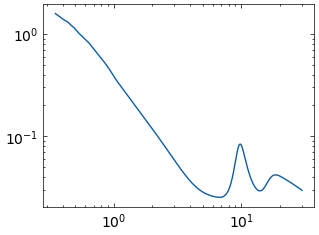

In [442]:
plt.plot()

In [454]:
print(Av)
print(Alam)

0.09652110638469458
[0.15256661 0.12397375 0.11518458 0.07179785 0.02547688 0.01626079
 0.01023467 0.00420376 0.00303535 0.00254467 0.0212896  0.01797314]


In [122]:
res=pd.read_csv("~/my_work/cigale/20231105_212049_out/results.txt",delim_whitespace=True)

In [124]:
pd.set_option('display.max_columns', 104)
res.dropna(axis=1)

id  bayes.sfh.sfr  bayes.sfh.sfr_err  bayes.sfh.sfr100Myrs  \
0  Q0100-BX172     257.408213          20.747612            148.770828   

   bayes.sfh.sfr100Myrs_err  bayes.sfh.sfr10Myrs  bayes.sfh.sfr10Myrs_err  \
0                 14.103827           249.365844                16.861125   

   bayes.G_lris  bayes.G_lris_err  bayes.Rs_lris  bayes.Rs_lris_err  \
0      0.001203          0.000049       0.001854           0.000058   

   bayes.Un_lris  bayes.Un_lris_err  bayes.hst.wfc3.F140W  \
0       0.000478           0.000027               0.00397   

   bayes.hst.wfc3.F140W_err  bayes.hst.wfc3.F160W  bayes.hst.wfc3.F160W_err  \
0                  0.000072              0.005498                  0.000044   

   bayes.mosfire_H  bayes.mosfire_H_err  bayes.mosfire_J  bayes.mosfire_J_err  \
0         0.005443             0.000076         0.003516             0.000004   

   bayes.mosfire_Ks  bayes.mosfire_Ks_err  bayes.spitzer.irac.ch1  \
0           0.00819              0.000061                0.009927   

   bayes.spitzer.irac.ch1_err  bayes.spitzer.irac.ch2  \
0                    0.000459                0.011315   

   bayes.spitzer.irac.ch2_err  bayes.spitzer.irac.ch3  \
0                    0.000552                0.013865   

   bayes.spitzer.irac.ch3_err  bayes.subaru.suprime.B  \
0                    0.000576                0.001209   

   bayes.subaru.suprime.B_err  best.chi_square  best.reduced_chi_square  \
0                    0.000056        19.537913                 1.776174   

   best.attenuation.B_B90  best.attenuation.E_BVs.nebular.continuum_old  \
0                1.526264                                           0.3   

   best.attenuation.E_BVs.nebular.continuum_young  \
0                                             0.3   

   best.attenuation.E_BVs.nebular.lines_old  \
0                                       0.3   

   best.attenuation.E_BVs.nebular.lines_young  \
0                                         0.3   

   best.attenuation.E_BVs.stellar.old  best.attenuation.E_BVs.stellar.young  \
0                                 0.3                                   0.3   

   best.attenuation.FUV  best.attenuation.V_B90  \
0              3.066789                1.235903   

   best.attenuation.ebvs_old_factor  best.attenuation.powerlaw_slope  \
0                               1.0                              0.0   

   best.attenuation.uv_bump_amplitude  best.attenuation.uv_bump_wavelength  \
0                                 0.0                                217.5   

   best.attenuation.uv_bump_width  best.nebular.f_dust  best.nebular.f_esc  \
0                            35.0                  0.0                 0.0   

   best.nebular.lines_width  best.nebular.logU  best.nebular.ne  \
0                     300.0               -2.0            100.0   

   best.nebular.zgas  best.sfh.age  best.sfh.age_burst  best.sfh.age_main  \
0               0.02         100.0                20.0              100.0   

   best.sfh.f_burst  best.sfh.tau_burst  best.sfh.tau_main  \
0               0.0                50.0              500.0   

   best.stellar.age_m_star  best.stellar.imf  best.stellar.metallicity  \
0                32.996367               1.0                      0.02   

   best.stellar.old_young_separation_age  best.universe.age  \
0                                   10.0          2906.2355   

   best.universe.luminosity_distance  best.universe.redshift  \
0                       5.841394e+26                   2.312   

   best.attenuation.nebular.continuum_old  \
0                            8.588303e+34   

   best.attenuation.nebular.continuum_young  \
0                              2.596998e+37   

   best.attenuation.nebular.lines_old  best.attenuation.nebular.lines_young  \
0                        1.870069e+35                          5.654861e+37   

   best.attenuation.stellar.old  best.attenuation.stellar.young  \
0                  1.930876e+38                    4.652654e+38   

   best.dust

In [272]:
flam=[]
flamsig=[]
cenlambda=[]
for ind,ff in enumerate(all_filters):
    if ff not in ['f140w','f160w','f125w'] and photentry.columns[1+ind*2].data[0] < 999.:
        cenlambda.append(effective_wave[ff])
        flam.append(MAB2Flam(photentry.columns[1+ind*2].data[0],effective_wave[ff]*1e-8)*1e-8*1e17)
        flamsig.append(photentry.columns[2+ind*2].data[0]*flam[-1]/1.086)

In [274]:
print("saving photometry data to",datapath+"/photometry/inphot.txt")
np.savetxt(datapath+"/photometry/inphot.txt",np.array([cenlambda,flam,flamsig]).T)

saving photometry data to /Users/yuanze/KBSS/Q1549/BX101/photometry/inphot.txt


In [243]:
import sys
sys.path.append('/Users/yuanze/GalfitS/src')
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["GS_DATA_PATH"] = "/Users/yuanze/Documents"
import gsutils


7.092367571498858e+17

In [245]:
fact=gsutils.ABmag_to_covf(24.53,effective_wave['Un_lris'])
print(24.53/fact)

3.458647588793255e-17


In [137]:
fname="mosfire_Ks"
fout=fname
fil=np.loadtxt("/disk/bifrost/yuanze/cigale-v2022.1/mosfire_filters/{}.dat".format(fname))

In [159]:
fil=np.loadtxt("/disk/bifrost/yuanze/cigale-v2022.1/database_builder/filters/gazpar/hst/wfc3/F140W.pb")

In [160]:
fil2=np.loadtxt("/disk/bifrost/yuanze/cigale-v2022.1/my_filters/f140w.bp")#.format(fname))

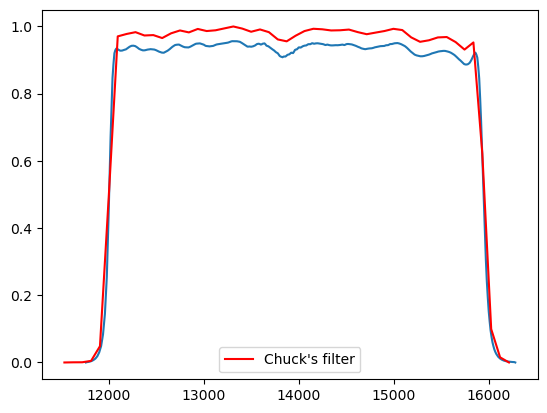

In [161]:
#fil[:,0]=fil[::-1,0]
#fil[:,1]=fil[::-1,1]
plt.plot(fil[:,0],fil[:,1])
plt.plot(fil2[:,0],fil2[:,1],"r",label="Chuck's filter")
plt.legend()

In [162]:
print(fil2.shape)
print(fil.shape)

(51, 2)
(453, 2)


In [118]:
np.savetxt("/disk/bifrost/yuanze/cigale-v2022.1/mosfire_filters/{}".format(fout),fil,fmt="%.2f")

In [104]:
from astropy.modeling import models
from astropy import units as u
bb = models.BlackBody(temperature=5000*u.K,scale=1*u.erg/(u.cm**2*u.s*u.AA*u.sr))
bbinten=bb(fil[:,0] * u.AA)

Text(0.5, 0, 'Angstrom')

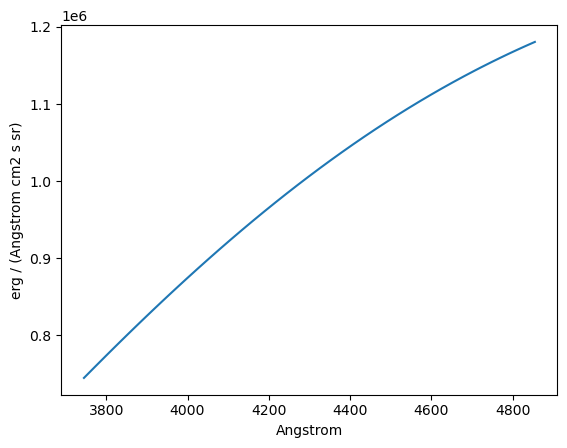

In [106]:
plt.plot(fil[:,0],bbinten)
nu=constants.c.to(u.cm/u.s)/(fil[:,0]*u.AA).to(u.cm)
plt.ylabel(bbinten.unit)
plt.xlabel(u.AA)

In [110]:
bbphot=bbinten/nu/constants.h.to(u.erg*u.s)

Text(0.5, 0, 'Angstrom')

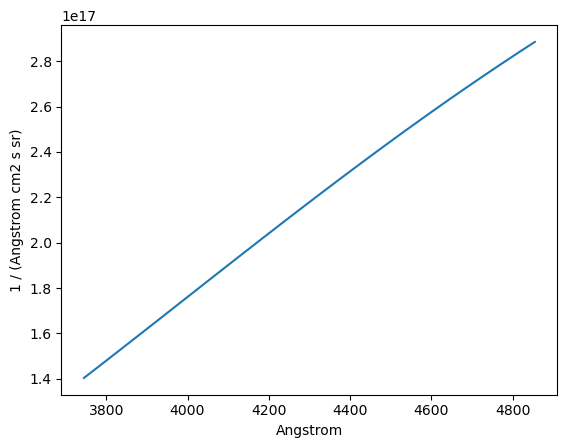

In [112]:
plt.plot(fil[:,0],bbphot)
plt.ylabel(bbphot.unit)
plt.xlabel(u.AA)

In [114]:
from scipy.integrate import simps
enerpho=simps(fil[:,0] * u.AA,fil[:,1]*constants.h.to(u.erg*u.s)*nu*bbphot)/simps(fil[:,0] * u.AA,fil[:,1])
enerflu=simps(fil[:,0] * u.AA,fil[:,1]*bbinten)/simps(fil[:,0] * u.AA,fil[:,1])

In [119]:
gch1=np.loadtxt("/disk/bifrost/yuanze/software/GalfitS/src/data/filters/ch1")
cch1=np.loadtxt("/disk/bifrost/yuanze/cigale-v2022.1/database_builder/filters/IRAC1.dat")

In [ ]:

plt.plot(gch1[:,0],gch1[:,1]*gch1[:,0]/np.sum(gch1[:,1]*gch1[:,0]),label="photon")
plt.plot(gch1[:,0],gch1[:,1]/np.sum(gch1[:,1]),label="energy")
plt.legend()

In [130]:
np.sum(gch1[:,1]*gch1[:,0]/np.sum(gch1[:,1]*gch1[:,0]))

1.0

In [169]:
taumain=pd.DataFrame([0.001, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 10, 12, 15, 20])

In [175]:
taumain*=1000

In [185]:
taumain.T.to_csv("~/KBSS/taumain",index=False)

In [187]:
from astropy.cosmology import Planck18
Planck18.age(15)

<Quantity 0.2682885 Gyr>

In [188]:
from dustmaps.config import config
config['data_dir'] = "/disk/bifrost/yuanze/software/dustmaps"
import dustmaps.sfd
dustmaps.sfd.fetch()

import dustmaps.csfd
dustmaps.csfd.fetch()

import dustmaps.planck
dustmaps.planck.fetch()

import dustmaps.planck
dustmaps.planck.fetch(which='GNILC')

import dustmaps.bayestar
dustmaps.bayestar.fetch()

import dustmaps.iphas
dustmaps.iphas.fetch()

import dustmaps.marshall
dustmaps.marshall.fetch()

import dustmaps.chen2014
dustmaps.chen2014.fetch()

import dustmaps.lenz2017
dustmaps.lenz2017.fetch()

import dustmaps.pg2010
dustmaps.pg2010.fetch()

import dustmaps.leike_ensslin_2019
dustmaps.leike_ensslin_2019.fetch()

import dustmaps.leike2020
dustmaps.leike2020.fetch()

import dustmaps.edenhofer2023
dustmaps.edenhofer2023.fetch()

import dustmaps.gaia_tge
dustmaps.gaia_tge.fetch()

Configuration file not found:

    /disk/bifrost/yuanze/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


 64.0 MiB of 64.0 MiB |  12.3 MiB/s |###################| 100% | ETA:  00:00:00

 64.0 MiB of 64.0 MiB |   8.9 MiB/s |###################| 100% | ETA:  00:00:00

191.4 MiB of 192.0 MiB |   8.8 MiB/s |################# |  99% | ETA:   0:00:00

 95.5 MiB of 96.0 MiB |   7.8 MiB/s |################## |  99% | ETA:   0:00:00

 33.7 MiB of ? |   2.6 MiB/s |#                          | N/A% | ETA:      N/A

KeyboardInterrupt: 